In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import calendar
import time
from matplotlib import colors
from sklearn import preprocessing
import cartopy.crs as crs
import cartopy.feature as cfeature

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [160]:
def get_model_rmse_months_clim_divs(
    model, fcast_and_error_df, max_fhour, var, units, minmax
):
    fcast_and_error_df = fcast_and_error_df.copy()
    fcast_and_error_df = fcast_and_error_df[
        fcast_and_error_df["lead_time_ONLY_HOURS"] <= max_fhour
    ]
    fcast_and_error_df[f"{var}_sq"] = fcast_and_error_df[var] ** 2
    rmse_months = (
        fcast_and_error_df.groupby([fcast_and_error_df.time.dt.month, "station"])[
            f"{var}_sq"
        ]
        .mean()
        .apply(np.sqrt)
    )
    rmse_months_stns = (
        fcast_and_error_df.groupby([fcast_and_error_df.time.dt.month, "station"])[
            f"{var}_sq"
        ]
        .mean()
        .apply(np.sqrt)
    )
    rmse_stns = (
        fcast_and_error_df.groupby(["station"])[f"{var}_sq"].mean().apply(np.sqrt)
    )

    new_column_order = [
        "Coastal",
        "Champlain Valley",
        "St. Lawrence Valley",
        "Hudson Valley",
        "Great Lakes",
        "Mohawk Valley",
        "Central Lakes",
        "Eastern Plateau",
        "Northern Plateau",
        "Western Plateau",
    ]
    return rmse_months, rmse_stns, rmse_months_stns


def get_monthly_rmse_data(fhour_end, var):
    (
        gfs_rmse_months,
        gfs_rmse_stns,
        gfs_rmse_months_stns,
    ) = get_model_rmse_months_clim_divs(
        "GFS",
        gfs_fcast_and_error_df,
        fhour_end,
        var,
        var_dict.get(var),
        var_val_range.get(var),
    )
    (
        nam_rmse_months,
        nam_rmse_stns,
        nam_rmse_months_stns,
    ) = get_model_rmse_months_clim_divs(
        "NAM",
        nam_fcast_and_error_df,
        fhour_end,
        var,
        var_dict.get(var),
        var_val_range.get(var),
    )

    gfs_rmse_months = gfs_rmse_months.reset_index()
    nam_rmse_months = nam_rmse_months.reset_index()

    gfs_rmse_months["NWP Model"] = "GFS"
    nam_rmse_months["NWP Model"] = "NAM"

    print("GFS", gfs_rmse_months[f"{var}_sq"].mean())
    print("NAM", nam_rmse_months[f"{var}_sq"].mean())

    if fhour_end <= 18:
        (
            hrrr_rmse_months,
            hrrr_rmse_stns,
            hrrr_rmse_months_stns,
        ) = get_model_rmse_months_clim_divs(
            "HRRR",
            hrrr_fcast_and_error_df,
            fhour_end,
            var,
            var_dict.get(var),
            var_val_range.get(var),
        )
        hrrr_rmse_months = hrrr_rmse_months.reset_index()
        hrrr_rmse_months["NWP Model"] = "HRRR"
        print("HRRR", hrrr_rmse_months[f"{var}_sq"].mean())
        rmse_to_plot = pd.concat([gfs_rmse_months, nam_rmse_months, hrrr_rmse_months])
    else:
        rmse_to_plot = pd.concat([gfs_rmse_months, nam_rmse_months])

    return rmse_to_plot


def plot_rmse_boxplots(df, fhour_end, var):
    rmse_to_plot = df
    palette_DJF = {"GFS": "dodgerblue", "NAM": "dodgerblue", "HRRR": "dodgerblue"}
    palette_MAM = {"GFS": "darkorchid", "NAM": "darkorchid", "HRRR": "darkorchid"}
    palette_JJA = {"GFS": "darkgreen", "NAM": "darkgreen", "HRRR": "darkgreen"}
    palette_SON = {"GFS": "coral", "NAM": "coral", "HRRR": "coral"}
    h_ind = 3
    if fhour_end >= 18:
        palette_DJF.pop("HRRR", None)
        palette_MAM.pop("HRRR", None)
        palette_JJA.pop("HRRR", None)
        palette_SON.pop("HRRR", None)
        h_ind = h_ind - 1

    plt.figure(figsize=(12, 5), dpi=100)
    ax = sns.boxplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot,
        hue="NWP Model",
        width=0.7,
        zorder=4,
        palette="binary",
        medianprops=dict(color="white"),
    )
    sns.stripplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot[rmse_to_plot["time"].isin([12, 1, 2])],
        hue="NWP Model",
        size=5,
        dodge=True,
        zorder=5,
        palette=palette_DJF,
    )
    sns.stripplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot[rmse_to_plot["time"].isin([3, 4, 5])],
        hue="NWP Model",
        size=5,
        dodge=True,
        zorder=5,
        palette=palette_MAM,
    )
    sns.stripplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot[rmse_to_plot["time"].isin([6, 7, 8])],
        hue="NWP Model",
        size=5,
        dodge=True,
        zorder=5,
        palette=palette_JJA,
    )
    sns.stripplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot[rmse_to_plot["time"].isin([9, 10, 11])],
        hue="NWP Model",
        size=5,
        dodge=True,
        zorder=5,
        palette=palette_SON,
    )
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(
        handles[0:h_ind] + handles[h_ind::h_ind],
        labels[0:h_ind] + ["DJF", "MAM", "JJA", "SON"],
        loc=2,
        borderaxespad=0.0,
    )
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.4, zorder=1)
    plt.ylabel(f"RMSE t2m_error")
    plt.ylim(ymax=5.0, ymin=0.0)
    plt.xlabel("Station")
    plt.tight_layout()

In [3]:
def read_data(init):
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # need to remove the random forecasts that have forecast hours 0
    # these are random because they only exist in the files that Ryan T. provided
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [4]:
def err_plot(df, month, up):
    projPC = crs.PlateCarree()
    latN = df["lat"].max() + 1
    latS = df["lat"].min() - 1
    lonW = df["lon"].max() + 1
    lonE = df["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plotter = ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c=df["t2m_error_sq"],
        s=df["t2m_error_sq"] * 50,
        marker="o",
        edgecolor="black",
        cmap="jet",
        transform=crs.PlateCarree(),
    )
    titl_Str = f"t2m_Forecast Error {up} {month}"
    ax.set_title(titl_Str, size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()
    fig.colorbar(plotter, ax=ax)

In [5]:
def count_plot(tops, bottoms, month):
    projPC = crs.PlateCarree()
    latN = 45.5
    latS = 40
    lonW = -80
    lonE = -71.5
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plotter = ax.scatter(
        x=tops["lon"],
        y=tops["lat"],
        c="g",
        s=50,
        marker="v",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    plotter2 = ax.scatter(
        x=bottoms["lon"],
        y=bottoms["lat"],
        c="orange",
        s=50,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Best/Worst Sites by Error {month}", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [71]:
def count_plot_top(df):
    projPC = crs.PlateCarree()
    latN = 45.5
    latS = 40
    lonW = -80
    lonE = -71.5
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plotter = ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c="g",
        s=50,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Top 10% Sites by Error", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [72]:
def count_plot_bott(df):
    projPC = crs.PlateCarree()
    latN = 45.5
    latS = 40
    lonW = -80
    lonE = -71.5
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plotter = ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c="r",
        s=50,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Bottom 10% Sites by Error", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [150]:
def plot_model_rmse_heatmap_fhours_clim_divs(
    model, fcast_and_error_df, var, units, minmax, stations
):
    fcast_and_error_df = fcast_and_error_df.copy()
    fcast_and_error_df[f"{var}_sq"] = fcast_and_error_df[var] ** 2
    fcast_and_error_df = fcast_and_error_df[fcast_and_error_df["new_tp_error_sq"] <= 18]
    fcast_and_error_df = fcast_and_error_df[fcast_and_error_df["lead_time_HOUR"] < 25]
    fcast_and_error_df = fcast_and_error_df[fcast_and_error_df["lead_time_HOUR"] != 0]
    fcast_and_error_df = fcast_and_error_df[fcast_and_error_df["lead_time_DAY"] == 0]
    rmse = (
        fcast_and_error_df.groupby(["lead_time_HOUR", "station"])[f"{var}_sq"]
        .mean()
        .apply(np.sqrt)
    )

    rmse_unstacked = rmse.unstack()[stations].T
    rmse_unstacked = rmse_unstacked.drop_duplicates()
    plt.figure(figsize=(20, 5))
    ax = sns.heatmap(
        rmse_unstacked,
        annot=True,
        linewidths=0.5,
        cmap=cm.YlGnBu,
        vmin=minmax[0],
        vmax=minmax[1],
        cbar_kws={"label": f"RMSE [{units}]"},
    )
    ax.set_xlabel("Forecast Hour")
    ax.set_title(f"{model}, {var.replace('_error','')}, Root Mean Square Error")
    plt.tight_layout()

In [74]:
def format_plot_df(tippity_df, keys):
    plot_df = pd.DataFrame()
    stat_ls = []
    lat_ls = []
    lon_ls = []
    for i, _ in enumerate(tippity_df["station"]):
        if tippity_df["station"].iloc[i] in keys:
            stations = tippity_df["station"].iloc[i]
            lats = tippity_df["lat"].iloc[i]
            lons = tippity_df["lon"].iloc[i]
            stat_ls.append(stations)
            lat_ls.append(lats)
            lon_ls.append(lons)
    plot_df["stations"] = stat_ls
    plot_df["lat"] = lat_ls
    plot_df["lon"] = lon_ls

    return plot_df

In [153]:
var_dict = {
    "d2m_error": "$^{\circ}$C",
    "u_dir_error": "$^{\circ}$",
    "u_total_error": "m s$^{-1}$",
    "t2m_error": "$^{\circ}$C",
    "new_tp_error": "mm",
    "prmsl_error": "hPa",
}

var_val_range = {
    "d2m_error": [1.0, 4.0],
    "u_dir_error": [40, 100],
    "u_total_error": [1, 3.5],
    "t2m_error": [1.0, 3.5],
    "new_tp_error": [0, 1.5],
    "prmsl_error": [-20, 100],
}

In [76]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [77]:
gfs_fcast_and_error_df.head()

station          valid_time                time    t2m_GFS    d2m_GFS  \
0    ADDI 2018-01-01 15:00:00 2018-01-01 12:00:00 -15.349532 -20.611755   
1    ADDI 2018-01-01 18:00:00 2018-01-01 12:00:00 -11.786198 -18.275512   
2    ADDI 2018-01-01 21:00:00 2018-01-01 12:00:00 -12.116852 -17.688393   
3    ADDI 2018-01-02 00:00:00 2018-01-01 12:00:00 -14.021501 -18.160225   
4    ADDI 2018-01-02 03:00:00 2018-01-01 12:00:00 -12.497983 -15.941133   

   u_total_GFS   u_dir_GFS   latitude  longitude  new_tp_GFS  ...  \
0     2.655496  288.477132  42.040359 -77.237259    0.000000  ...   
1     5.396916  285.354245  42.040359 -77.237259    0.005045  ...   
2     5.713116  286.574791  42.040359 -77.237259    0.024612  ...   
3     5.958310  273.989092  42.040359 -77.237259    0.010090  ...   
4     5.731337  300.191211  42.040359 -77.237259    0.140135  ...   

   prmsl_error   t2m_nysm   d2m_nysm  u_total_nysm  u_dir_nysm  new_tp_nysm  \
0    66.532533 -16.211229 -20.564865      1.854602  260.777710     0.000000   
1    66.223569 -12.779670 -18.921921      4.014196  244.369293     0.000000   
2    65.764059 -12.434510 -16.971771      2.923199  307.399109     0.000000   
3    65.920914 -13.972590 -19.079498      2.254292  282.835999     0.149994   
4    66.428000 -13.941200 -16.723541      2.284459  282.010406     0.000000   

   prmsl_nysm  lead_time_DAY  lead_time_HOUR  lead_time_ONLY_HOURS  
0  965.472778              0               3                   3.0  
1  963.408386              0               6                   6.0  
2  962.831970              0               9                   9.0  
3  963.546021              0              12                  12.0  
4  963.969604              0              15                  15.0  

[5 rows x 27 columns]

In [78]:
gfs_fcast_and_error_df.keys()

Index(['station', 'valid_time', 'time', 't2m_GFS', 'd2m_GFS', 'u_total_GFS',
       'u_dir_GFS', 'latitude', 'longitude', 'new_tp_GFS', 'prmsl_GFS', 'orog',
       't2m_error', 'd2m_error', 'u_total_error', 'u_dir_error',
       'new_tp_error', 'prmsl_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm',
       'u_dir_nysm', 'new_tp_nysm', 'prmsl_nysm', 'lead_time_DAY',
       'lead_time_HOUR', 'lead_time_ONLY_HOURS'],
      dtype='object')

In [79]:
rmse_to_plot = get_monthly_rmse_data(18, "new_tp_error")

GFS 1.3113581095370193
NAM 0.7274190036726051
HRRR 0.8196309490568423


In [80]:
rmse_to_plot = rmse_to_plot.sort_values(by=["new_tp_error_sq"])
rmse_to_plot

time station  new_tp_error_sq NWP Model
170      2    ESSX         0.169368       NAM
233      2    TICO         0.176521       NAM
1285    11    CLIF         0.177799       NAM
148      2    CHES         0.184700       NAM
1340    11    PENN         0.189914       NAM
...    ...     ...              ...       ...
1073     9    MANH         4.470827       GFS
769      7    BRON         4.576390       GFS
1110     9    STAT         5.076662       GFS
858      7    STAT         5.156346       GFS
1112     9    STON         5.370774       GFS

[4536 rows x 4 columns]

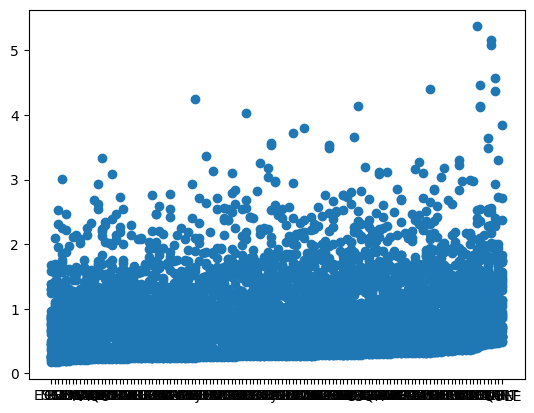

In [81]:
plt.scatter(rmse_to_plot["station"], rmse_to_plot["new_tp_error_sq"])

In [82]:
rmse_to_plot["new_tp_error_sq"].describe()

count    4536.000000
mean        0.952803
std         0.616339
min         0.169368
25%         0.491672
50%         0.793585
75%         1.267244
max         5.370774
Name: new_tp_error_sq, dtype: float64

In [83]:
diction = pd.read_csv("/home/aevans/nwp_bias/src/landtype/notebooks/nysm_coords.csv")

In [84]:
ny_stations = diction["station"]
ny_lats = diction["latitude"]
ny_lons = diction["longitude"]

In [85]:
latdict = dict(zip(diction.station, diction.latitude))
londict = dict(zip(diction.station, diction.longitude))

In [86]:
rmse_to_plot["lon"] = rmse_to_plot["station"].map(londict)
rmse_to_plot["lat"] = rmse_to_plot["station"].map(latdict)

In [87]:
rmse_to_plot

time station  new_tp_error_sq NWP Model        lon        lat
170      2    ESSX         0.169368       NAM -73.371895  44.313602
233      2    TICO         0.176521       NAM -73.418793  43.874691
1285    11    CLIF         0.177799       NAM -77.185181  43.014790
148      2    CHES         0.184700       NAM -73.777359  43.653900
1340    11    PENN         0.189914       NAM -76.987457  42.655781
...    ...     ...              ...       ...        ...        ...
1073     9    MANH         4.470827       GFS -73.964485  40.767544
769      7    BRON         4.576390       GFS -73.893524  40.872482
1110     9    STAT         5.076662       GFS -74.148499  40.604015
858      7    STAT         5.156346       GFS -74.148499  40.604015
1112     9    STON         5.370774       GFS -73.131683  40.919121

[4536 rows x 6 columns]

In [88]:
nysm_df = rmse_to_plot[rmse_to_plot["time"] == 1]

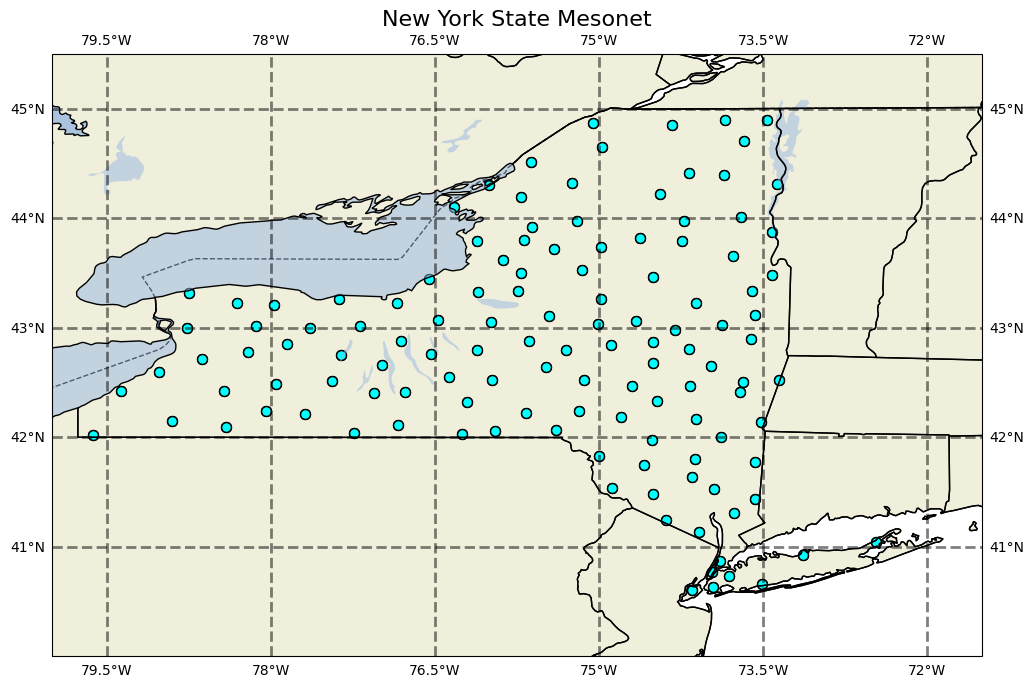

In [89]:
projPC = crs.PlateCarree()
latN = 45.5
latS = 40
lonW = -80
lonE = -71.5
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()})
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle="--")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.STATES)
ax.xticklabels_top = False
ax.ylabels_right = False
ax.gridlines(
    crs=crs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="black",
    alpha=0.5,
    linestyle="--",
)
plotter = ax.scatter(
    x=nysm_df["lon"],
    y=nysm_df["lat"],
    c="cyan",
    s=50,
    marker="o",
    edgecolor="black",
    transform=crs.PlateCarree(),
)
ax.set_title(f"New York State Mesonet", size=16)
ax.set_xlabel("Longitude", size=14)
ax.set_ylabel("Latitude", size=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid()

In [90]:
rmse_hrrr = rmse_to_plot[rmse_to_plot["NWP Model"] == "HRRR"]
rmse_hrrr

time station  new_tp_error_sq NWP Model        lon        lat
1340    11    PENN         0.198742      HRRR -76.987457  42.655781
148      2    CHES         0.201958      HRRR -73.777359  43.653900
170      2    ESSX         0.203869      HRRR -73.371895  44.313602
1285    11    CLIF         0.208631      HRRR -77.185181  43.014790
206      2    PENN         0.221408      HRRR -76.987457  42.655781
...    ...     ...              ...       ...        ...        ...
1112     9    STON         2.410268      HRRR -73.131683  40.919121
765      7    BKLN         2.497322      HRRR -73.953674  40.631763
858      7    STAT         2.502642      HRRR -74.148499  40.604015
791      7    DEPO         2.534229      HRRR -75.392197  42.068550
821      7    MANH         2.551143      HRRR -73.964485  40.767544

[1512 rows x 6 columns]

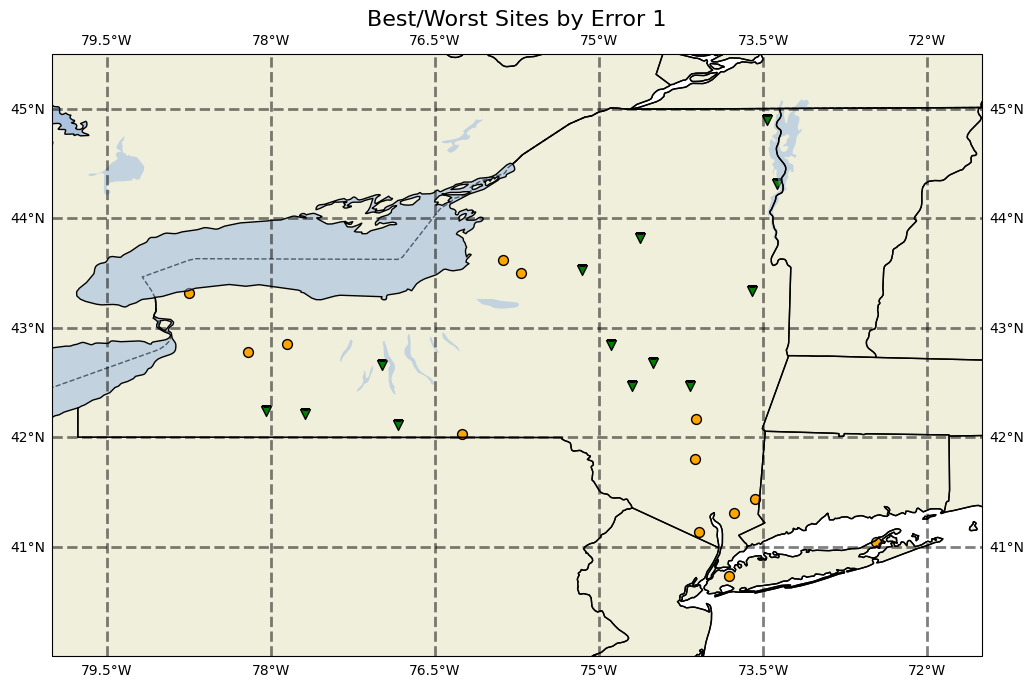

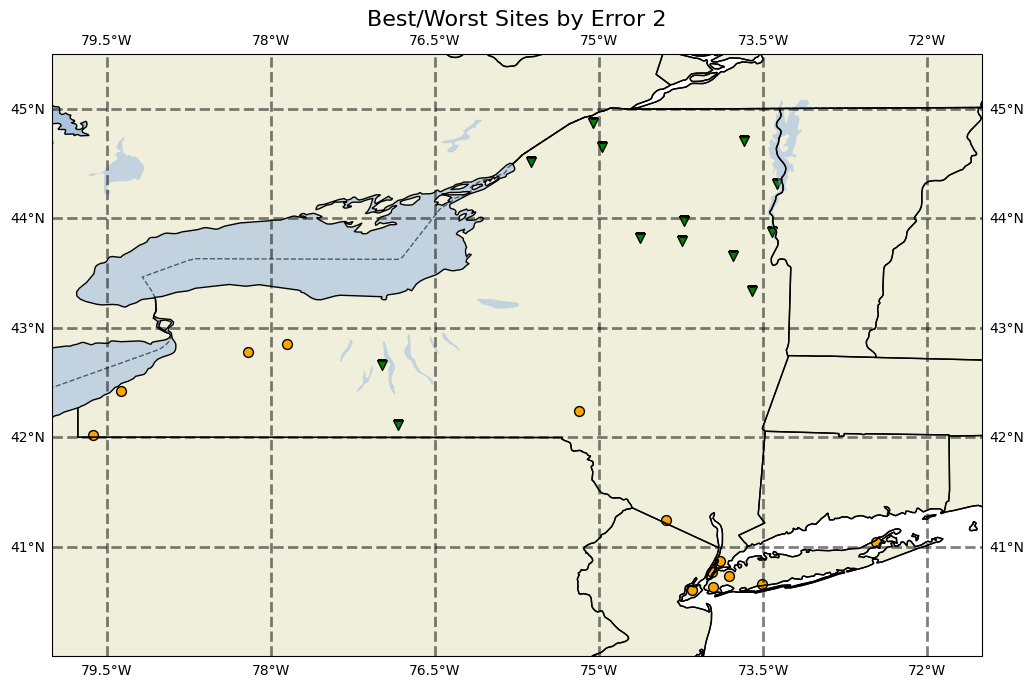

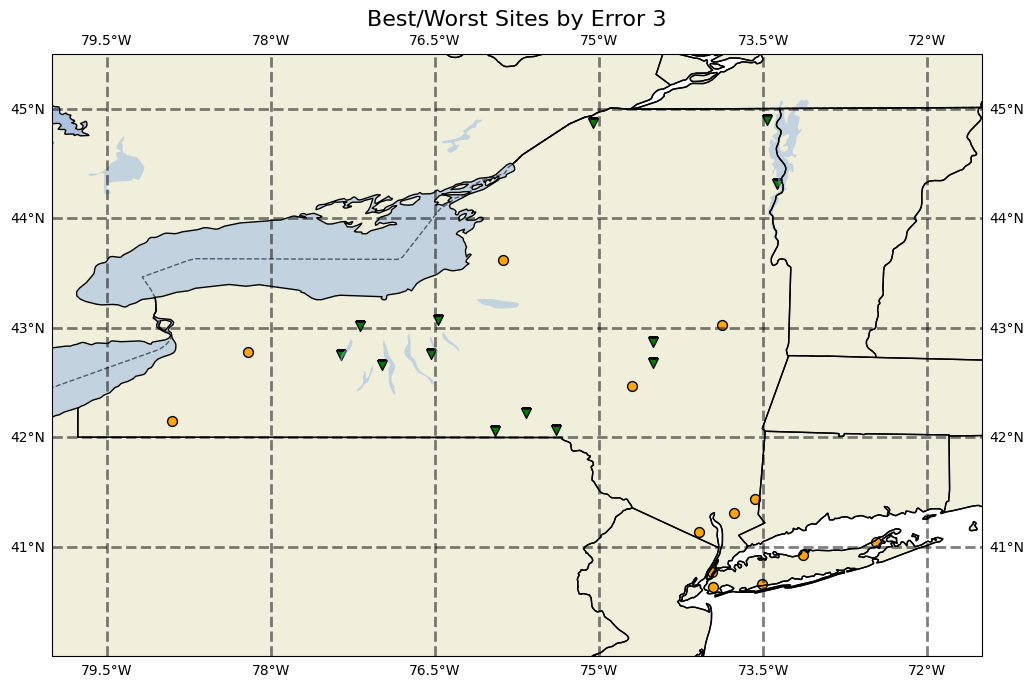

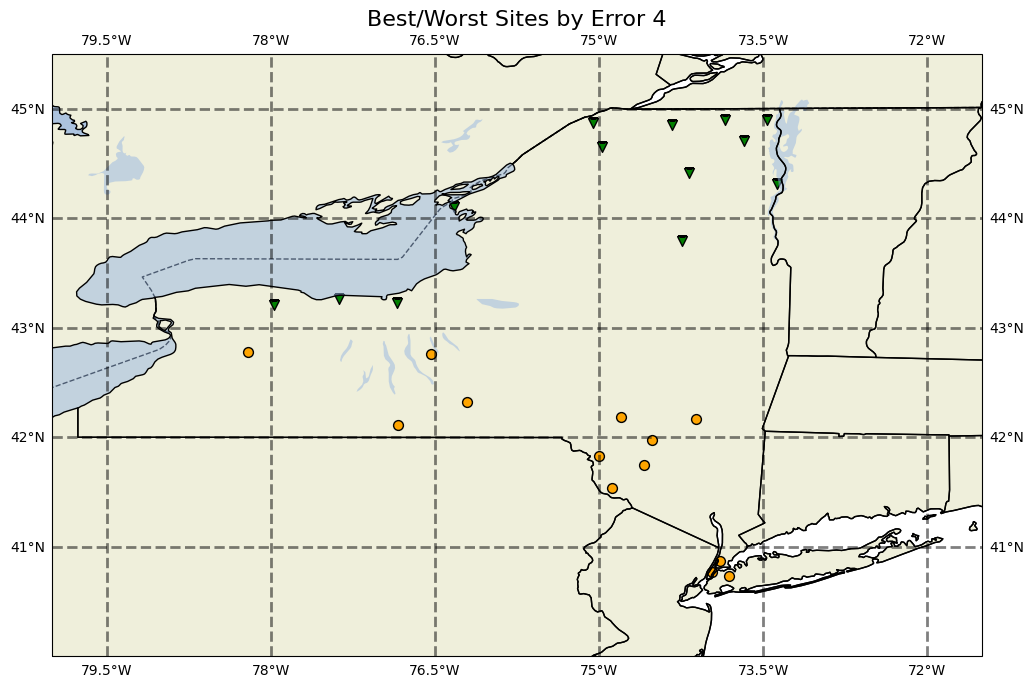

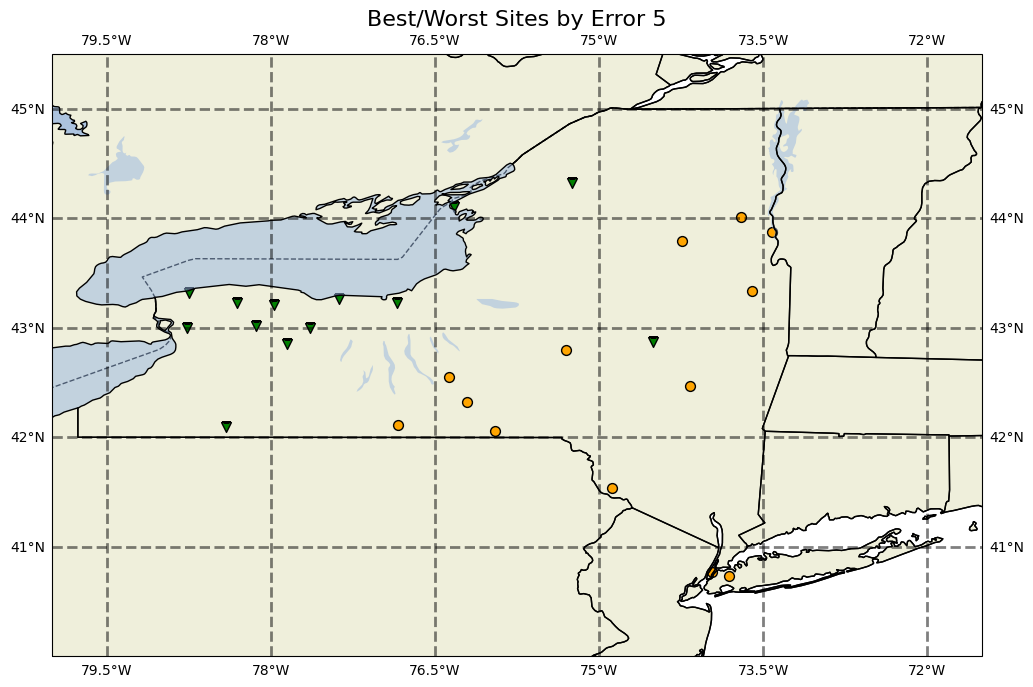

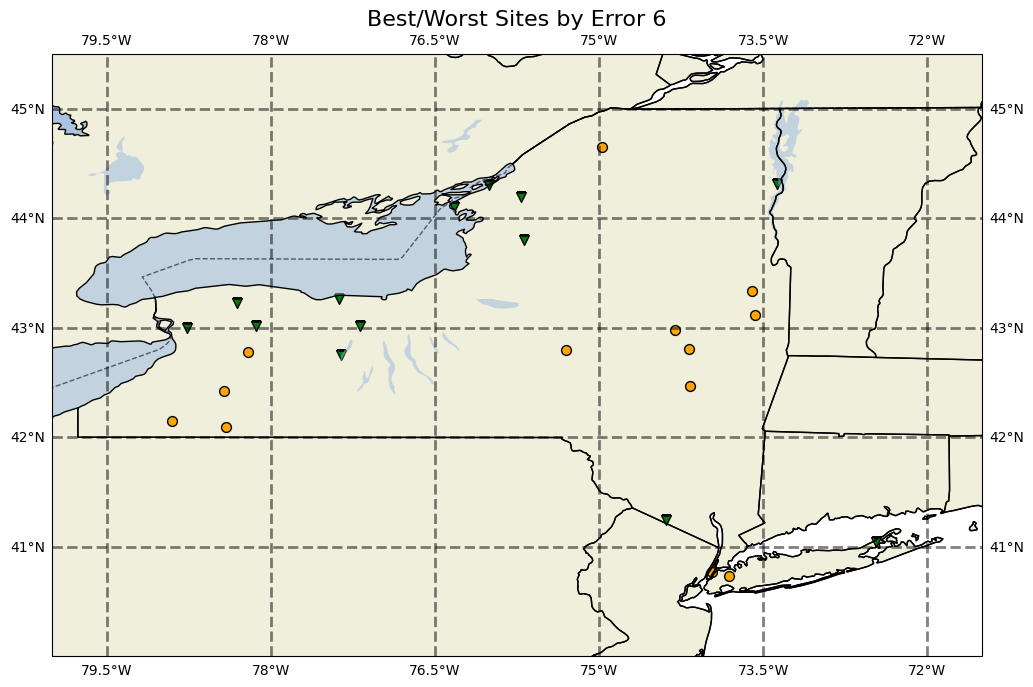

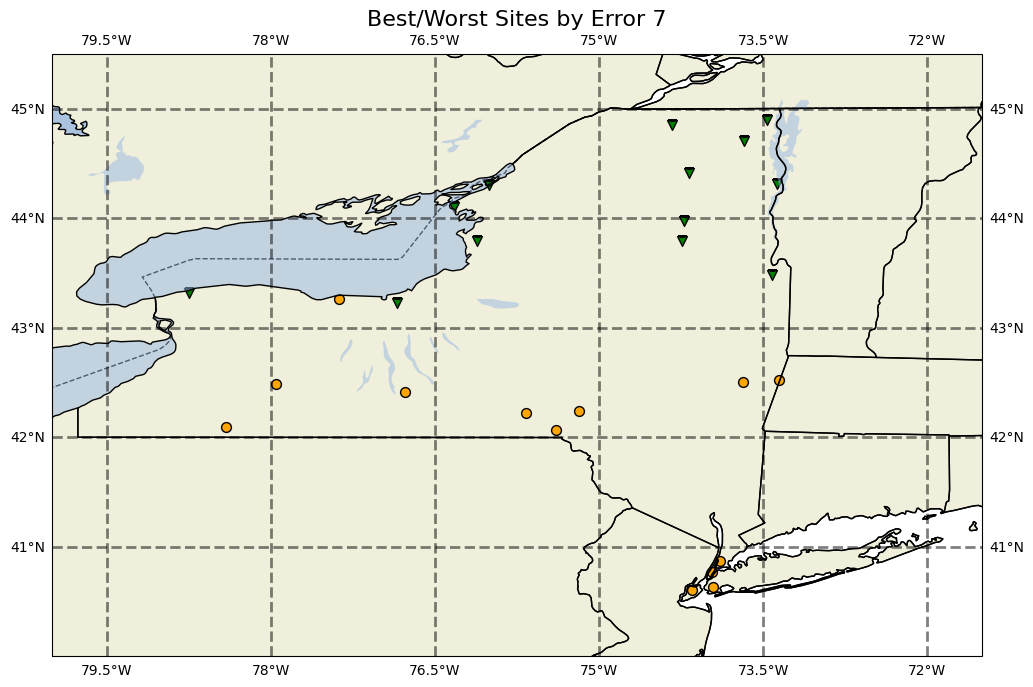

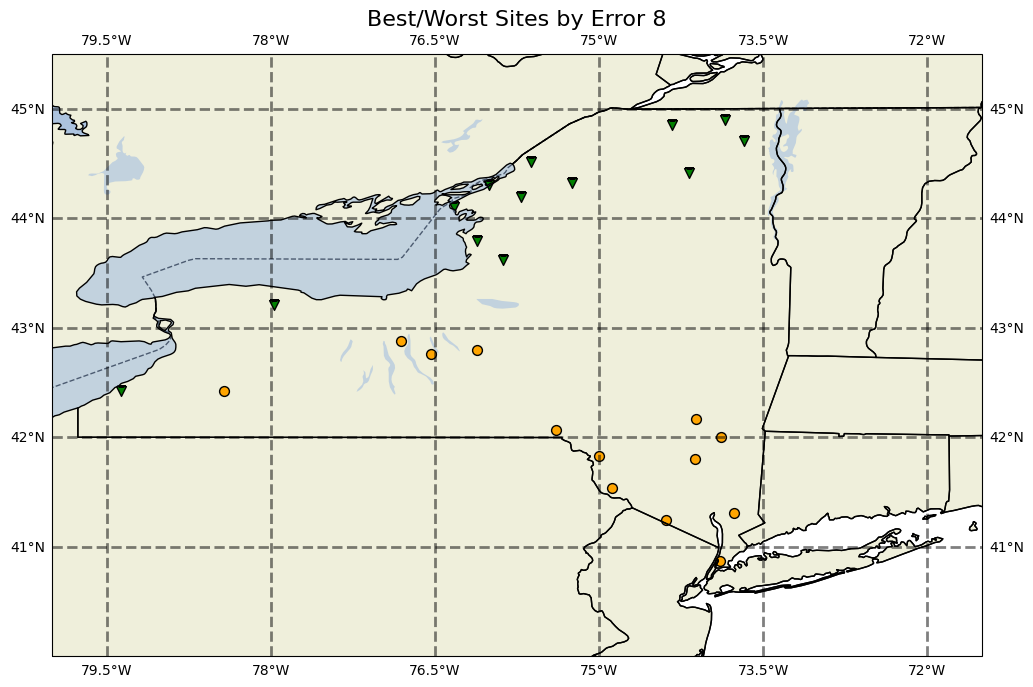

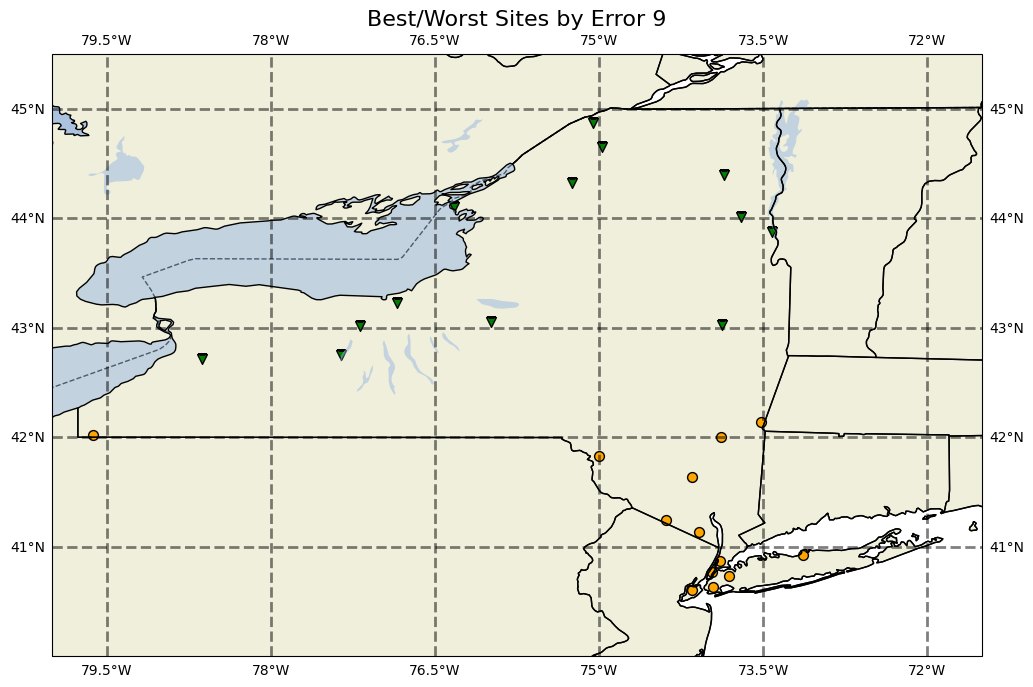

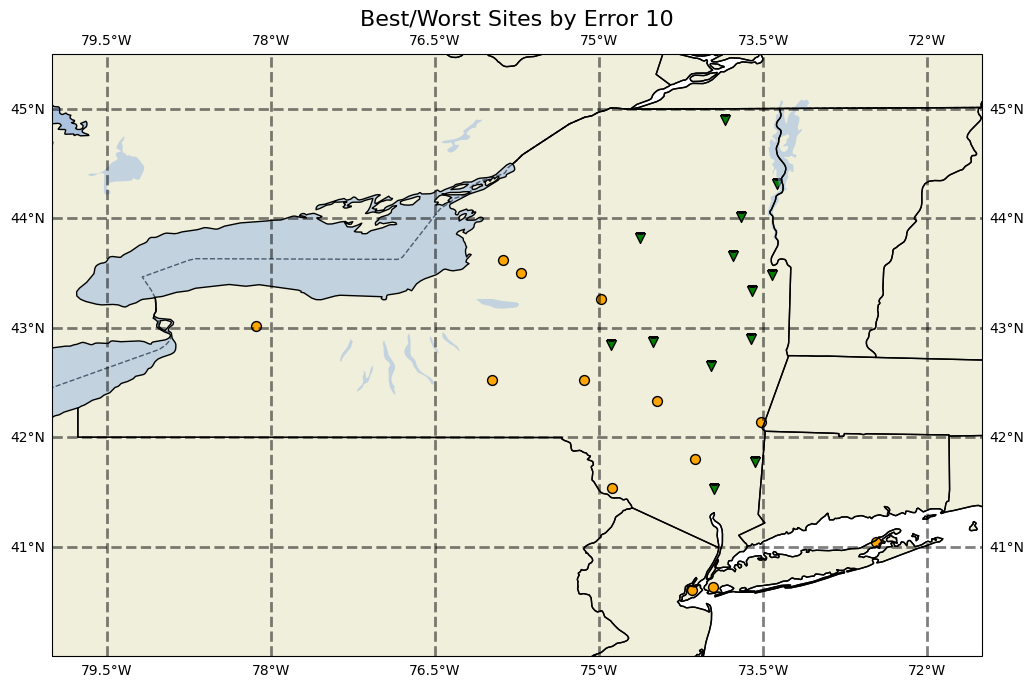

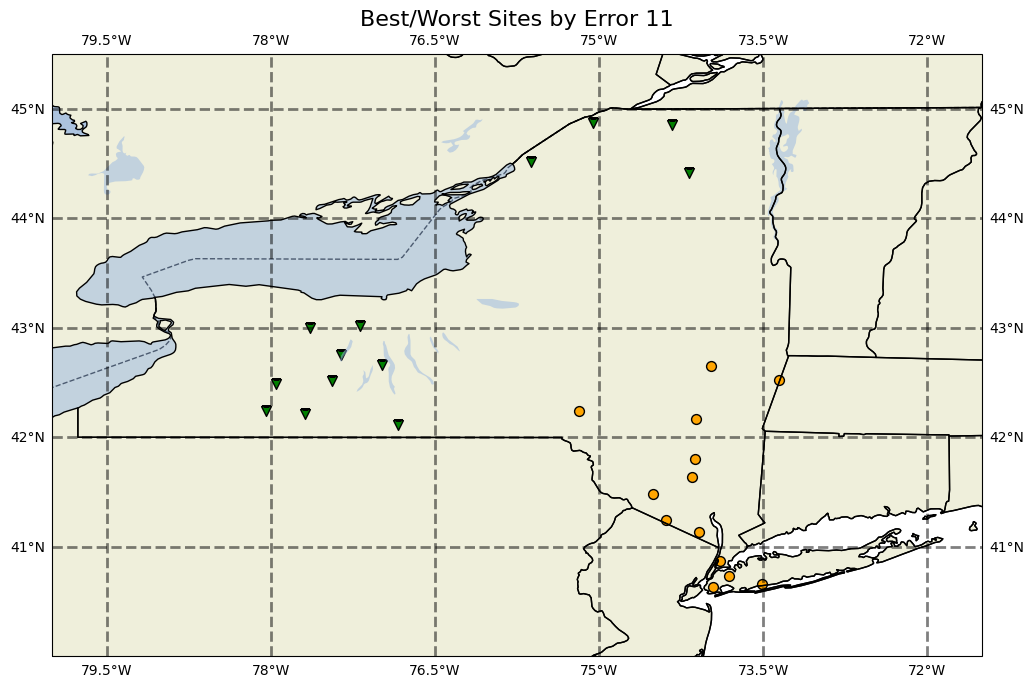

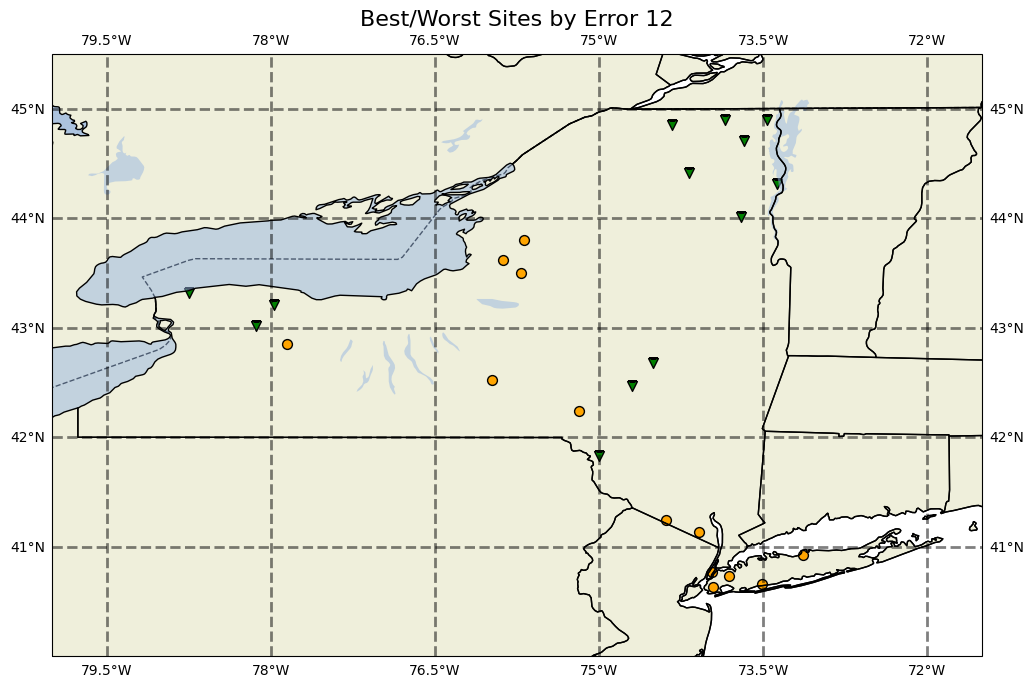

In [91]:
tops_ls = []
bottoms_ls = []


for i in np.arange(1, 13):
    # sort by month
    df_err = rmse_hrrr.where(rmse_hrrr["time"] == i).dropna()

    # get top and bottom
    top10 = df_err[:13]
    bottom10 = df_err[-13:]
    top10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_hrrr.csv"
    )
    bottom10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_hrrr.csv"
    )

    # plot
    count_plot(top10, bottom10, i)

In [92]:
tippity_df = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_hrrr.csv"
    )
    tippity_df = pd.concat([df, tippity_df])

In [93]:
rockbott_df = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_hrrr.csv"
    )
    rockbott_df = pd.concat([df, rockbott_df])

In [94]:
rockbott_df

Unnamed: 0  time station  new_tp_error_sq NWP Model        lon        lat
0         1440  12.0    HARR         0.516196      HRRR -75.688530  43.803520
1         1409  12.0    CINC         0.518544      HRRR -75.975624  42.522423
2         1502  12.0    WARW         0.525364      HRRR -74.390556  41.240360
3         1462  12.0    OSCE         0.529583      HRRR -75.711746  43.499149
4         1451  12.0    MANH         0.534240      HRRR -73.964485  40.767544
..         ...   ...     ...              ...       ...        ...        ...
8           18   1.0    BURT         0.523301      HRRR -78.749031  43.316990
9          115   1.0    WARS         0.526949      HRRR -78.208893  42.779930
10          84   1.0    QUEE         0.560017      HRRR -73.815857  40.734337
11          11   1.0    BREW         0.575822      HRRR -73.576424  41.439930
12         125   1.0    YORK         0.582219      HRRR -77.847763  42.855042

[156 rows x 7 columns]

In [95]:
keys = tippity_df["station"].value_counts()[:13].keys()
keys

Index(['ESSX', 'CAPE', 'SARA', 'LOUI', 'MALO', 'CHAZ', 'GABR', 'ELLE', 'BROC',
       'PENN', 'CLIF', 'SBRI', 'WOLC'],
      dtype='object')

In [96]:
plot_df = pd.DataFrame()
stat_ls = []
lat_ls = []
lon_ls = []
for i, _ in enumerate(tippity_df["station"]):
    if tippity_df["station"].iloc[i] in keys:
        stations = tippity_df["station"].iloc[i]
        lats = tippity_df["lat"].iloc[i]
        lons = tippity_df["lon"].iloc[i]
        stat_ls.append(stations)
        lat_ls.append(lats)
        lon_ls.append(lons)
plot_df["stations"] = stat_ls
plot_df["lat"] = lat_ls
plot_df["lon"] = lon_ls

In [97]:
keys = rockbott_df["station"].value_counts()[:13].keys()
keys

Index(['MANH', 'QUEE', 'BKLN', 'BRON', 'WARW', 'WARS', 'SUFF', 'ELDR', 'HFAL',
       'REDF', 'WANT', 'SOUT', 'WALT'],
      dtype='object')

In [98]:
plot_df_bott = format_plot_df(rockbott_df, keys)

In [99]:
plot_df_bott

stations        lat        lon
0      WARW  41.240360 -74.390556
1      MANH  40.767544 -73.964485
2      SUFF  41.130379 -74.089867
3      BKLN  40.631763 -73.953674
4      QUEE  40.734337 -73.815857
..      ...        ...        ...
63     SOUT  41.040081 -72.465866
64     SUFF  41.130379 -74.089867
65     HFAL  41.798801 -74.123123
66     WARS  42.779930 -78.208893
67     QUEE  40.734337 -73.815857

[68 rows x 3 columns]

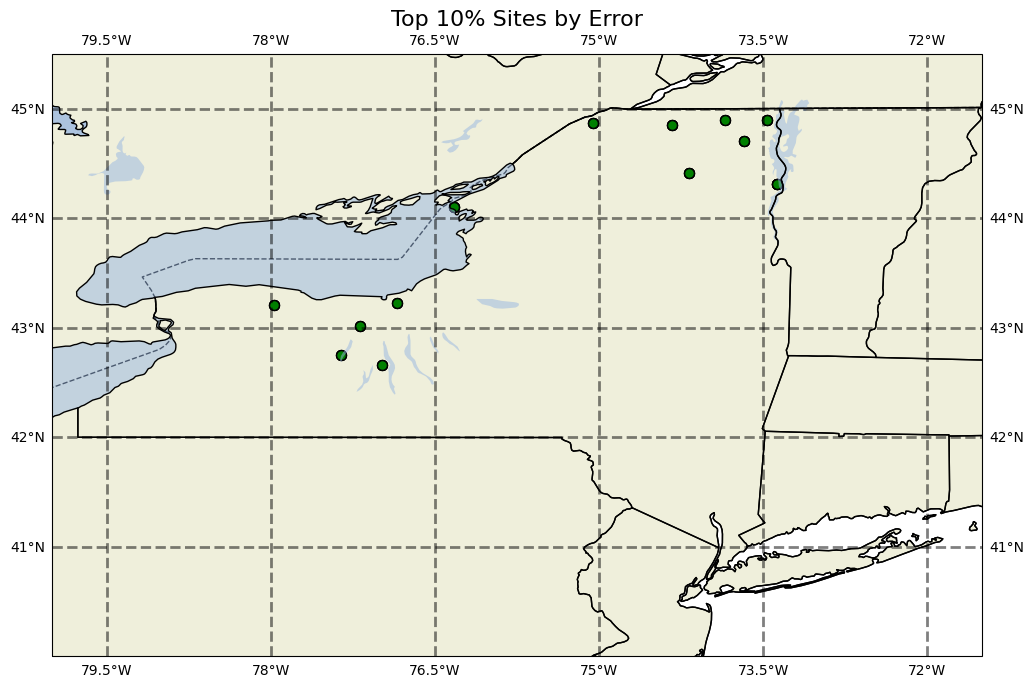

In [100]:
count_plot_top(plot_df)

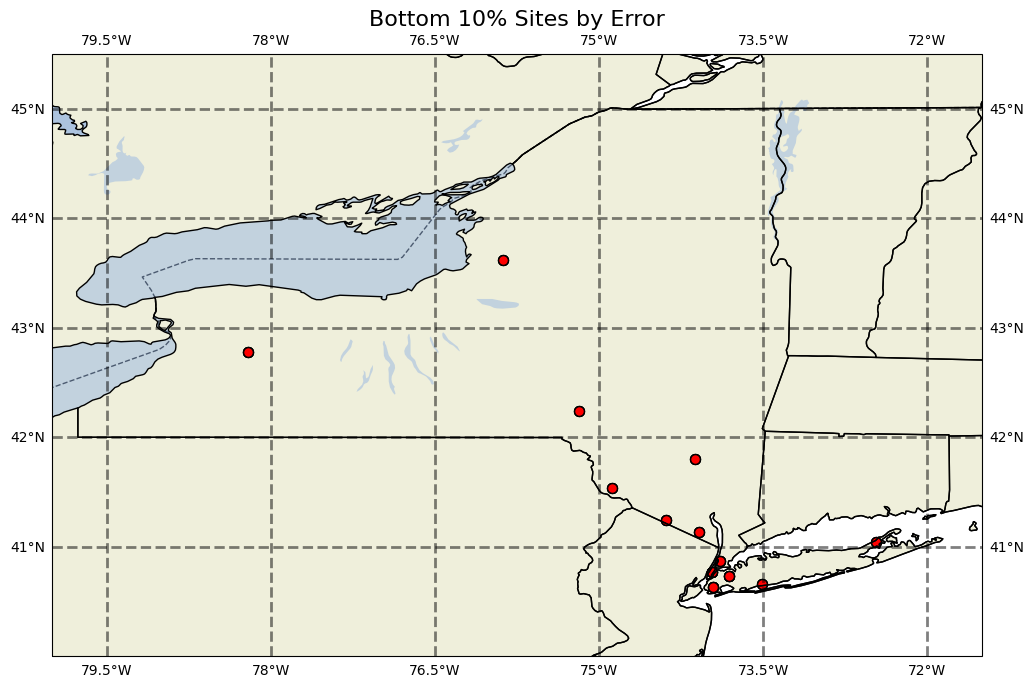

In [101]:
count_plot_bott(plot_df_bott)

# GFS

In [102]:
rmse_gfs = rmse_to_plot[rmse_to_plot["NWP Model"] == "GFS"]
rmse_gfs

time station  new_tp_error_sq NWP Model        lon        lat
0        1    ADDI         0.421417       GFS -77.237259  42.040359
1428    12    ELLE         0.437159       GFS -73.845016  44.895500
1430    12    ESSX         0.445841       GFS -73.371895  44.313602
1260    11    ADDI         0.448917       GFS -77.237259  42.040359
55       1    HART         0.454027       GFS -77.689735  42.211220
...    ...     ...              ...       ...        ...        ...
1073     9    MANH         4.470827       GFS -73.964485  40.767544
769      7    BRON         4.576390       GFS -73.893524  40.872482
1110     9    STAT         5.076662       GFS -74.148499  40.604015
858      7    STAT         5.156346       GFS -74.148499  40.604015
1112     9    STON         5.370774       GFS -73.131683  40.919121

[1512 rows x 6 columns]

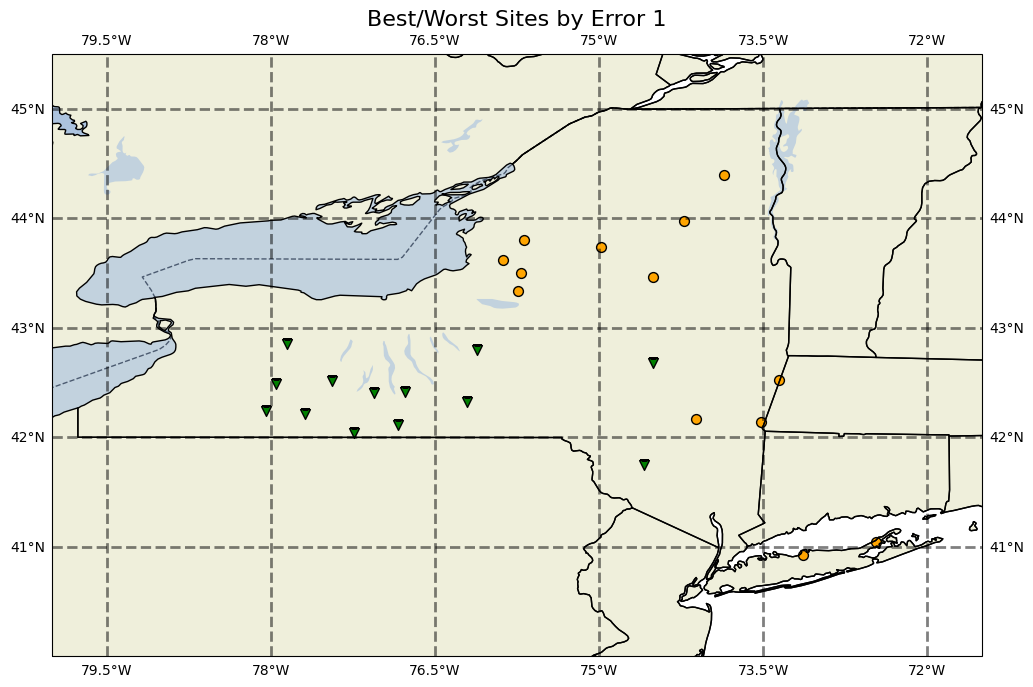

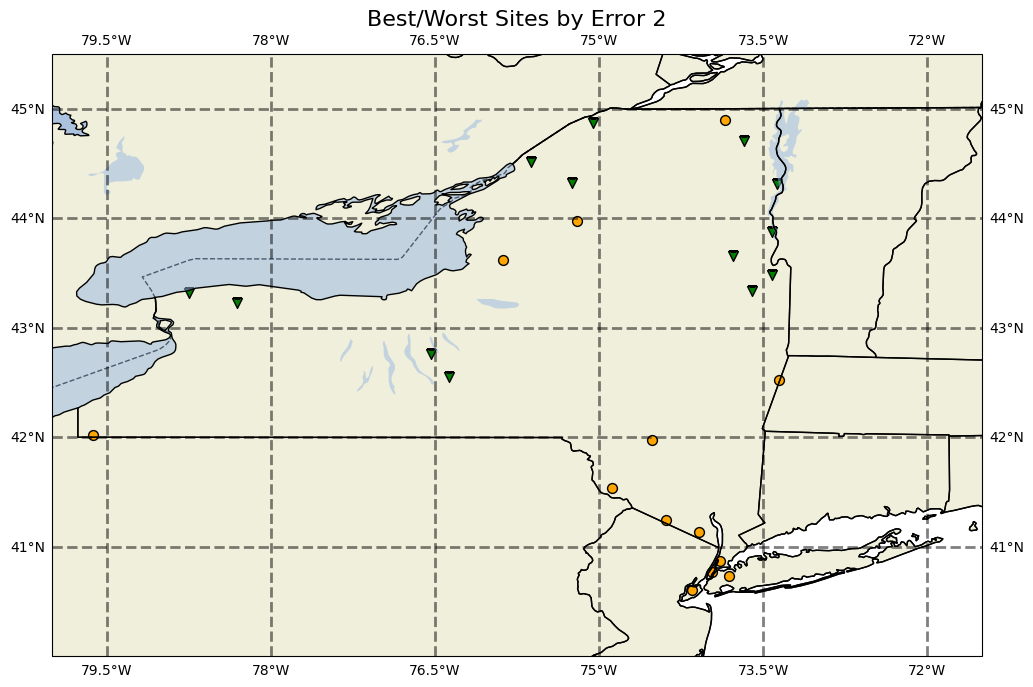

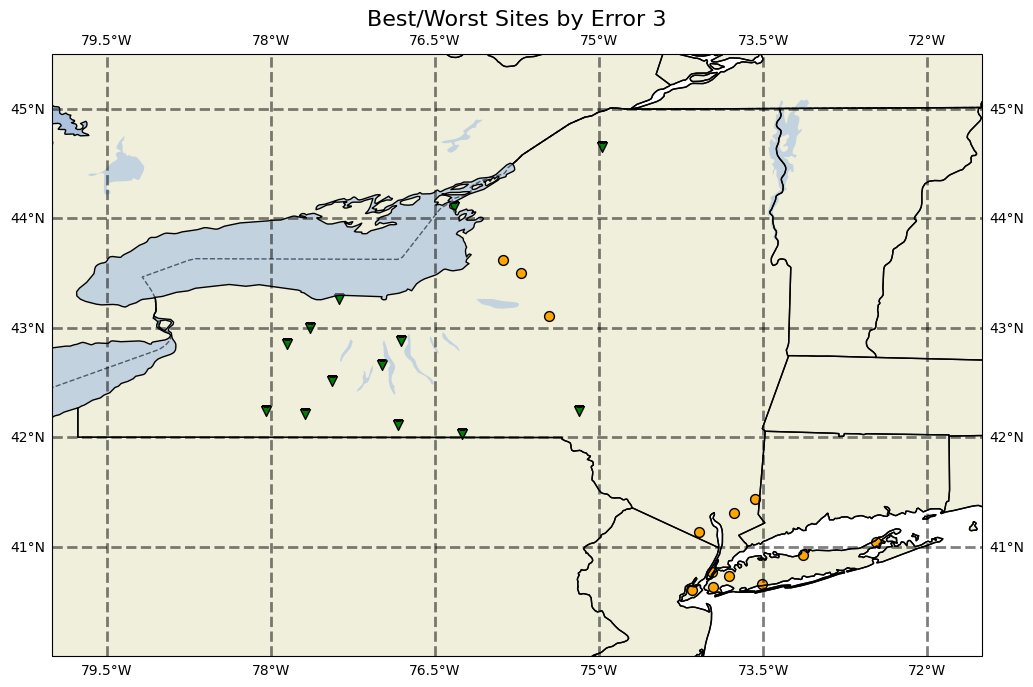

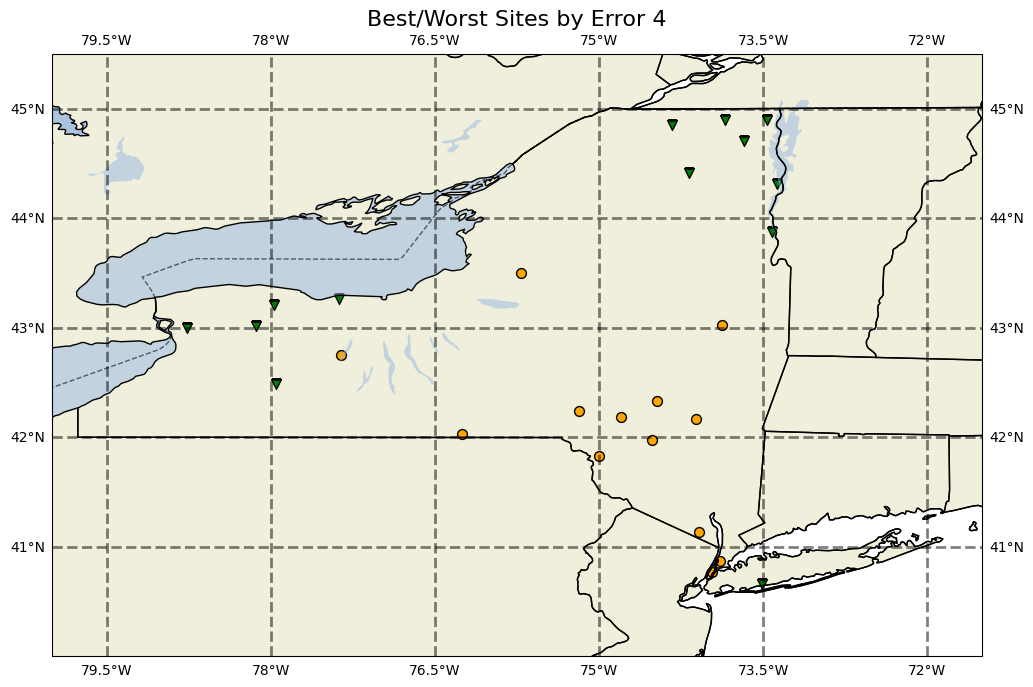

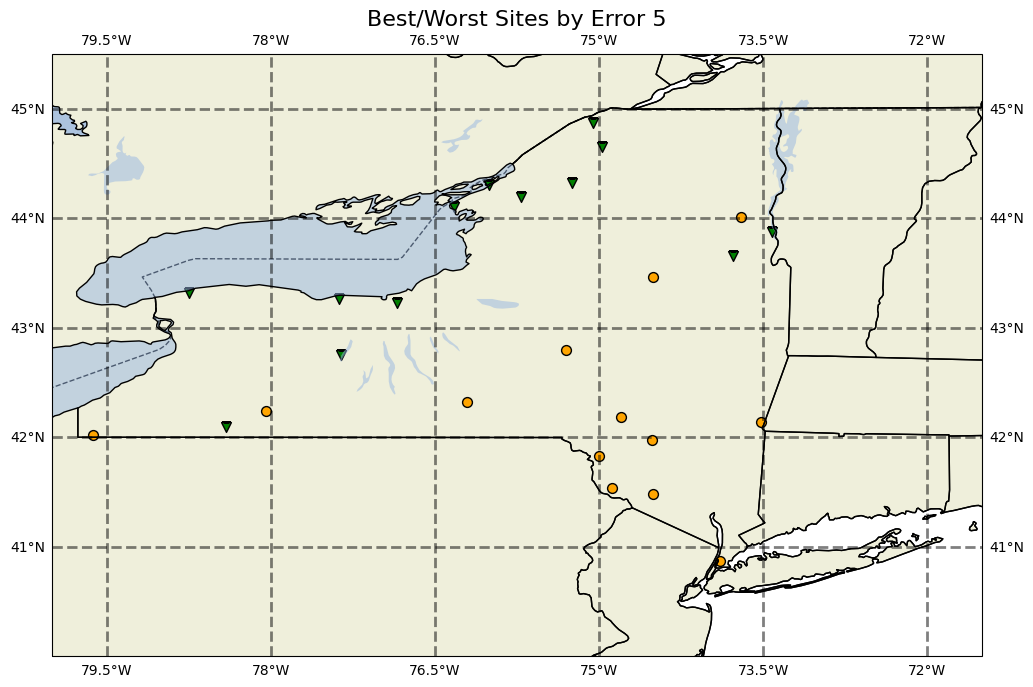

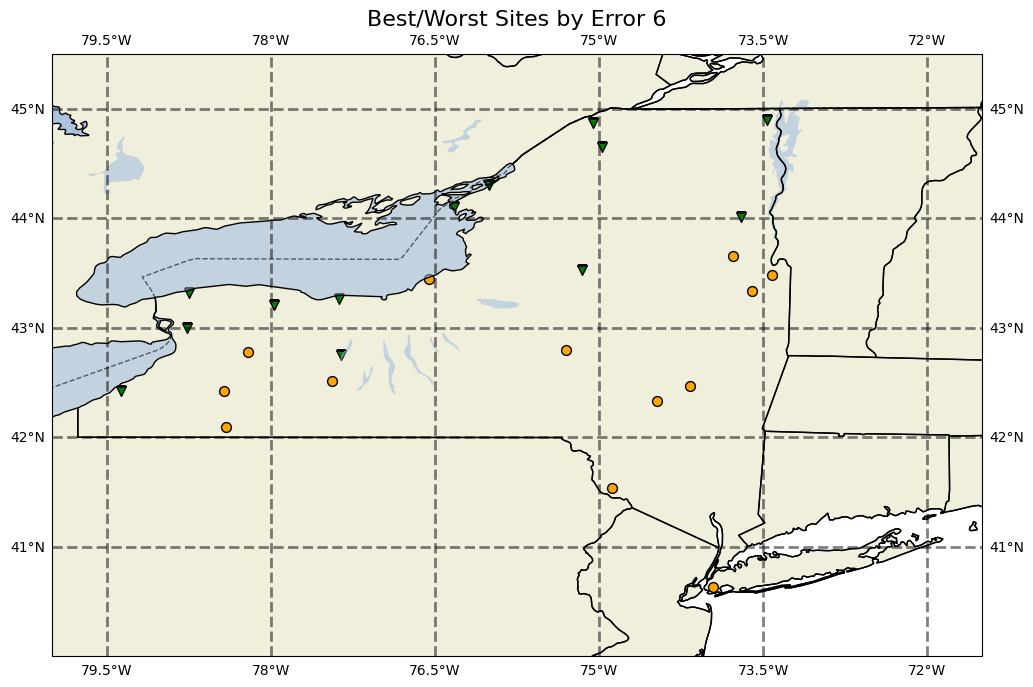

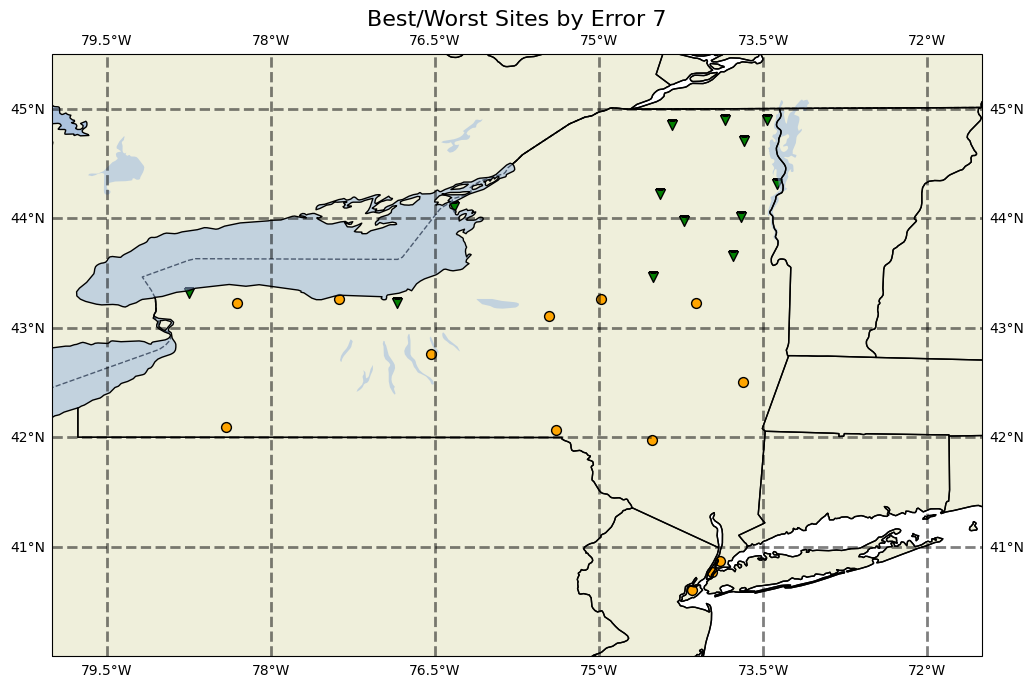

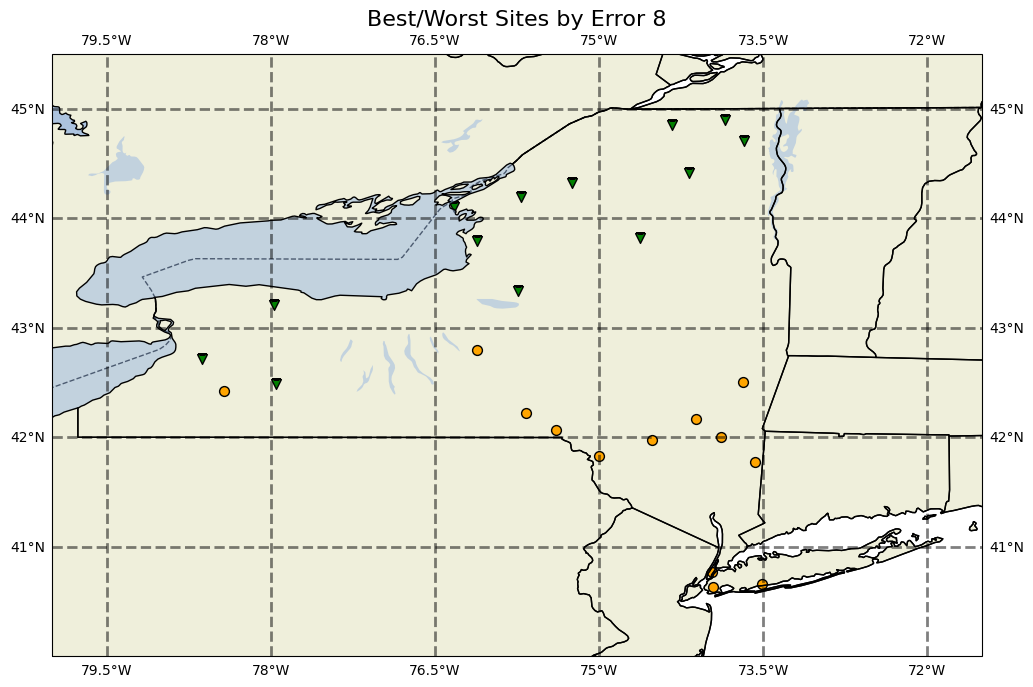

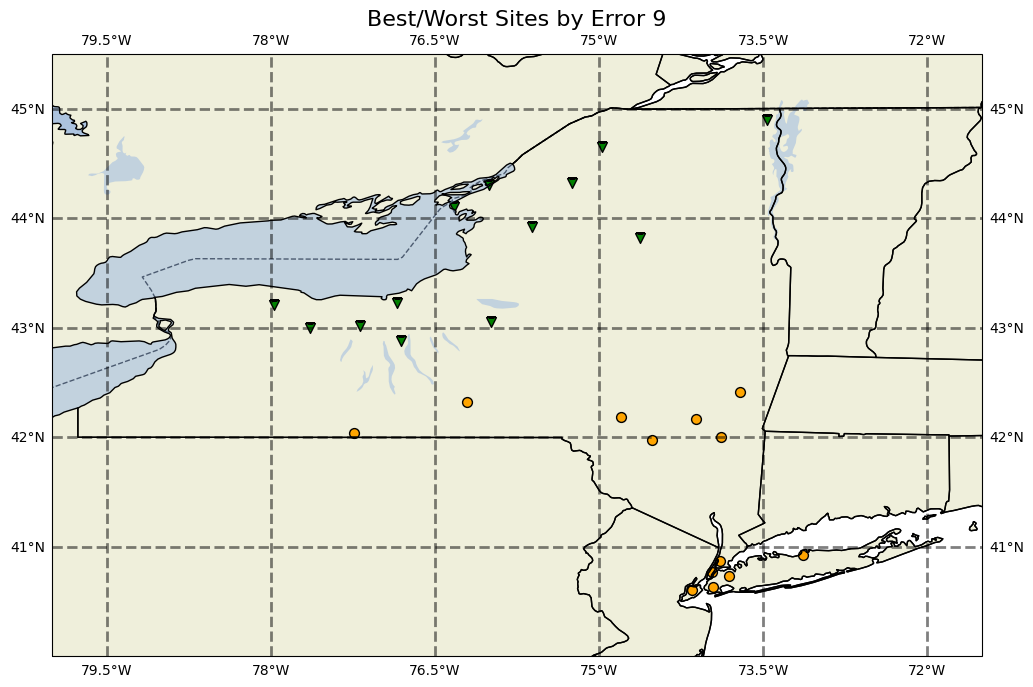

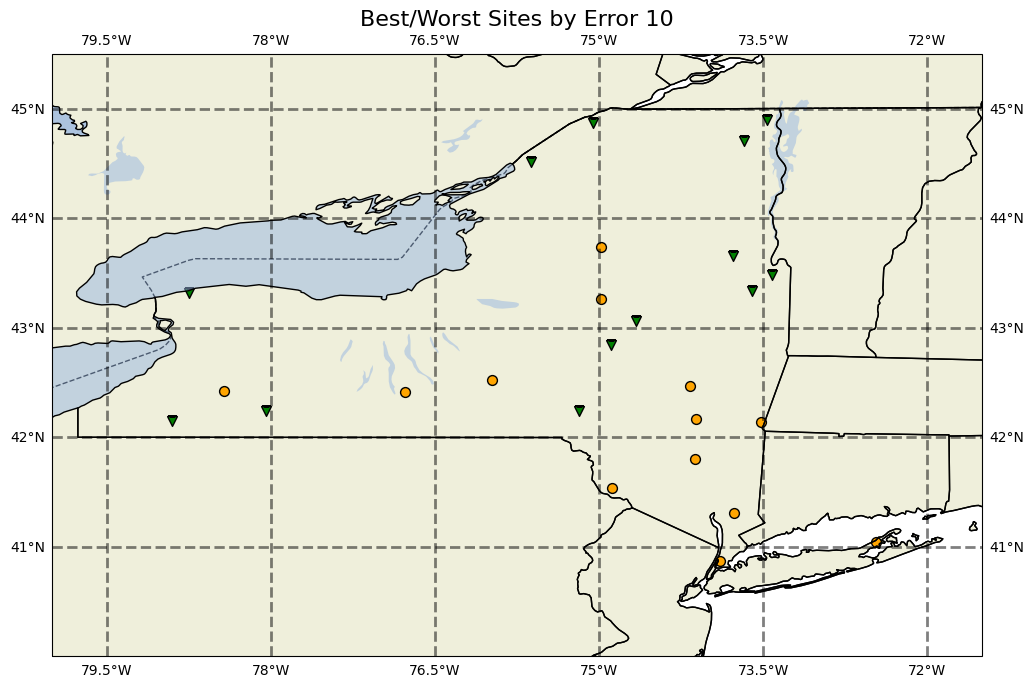

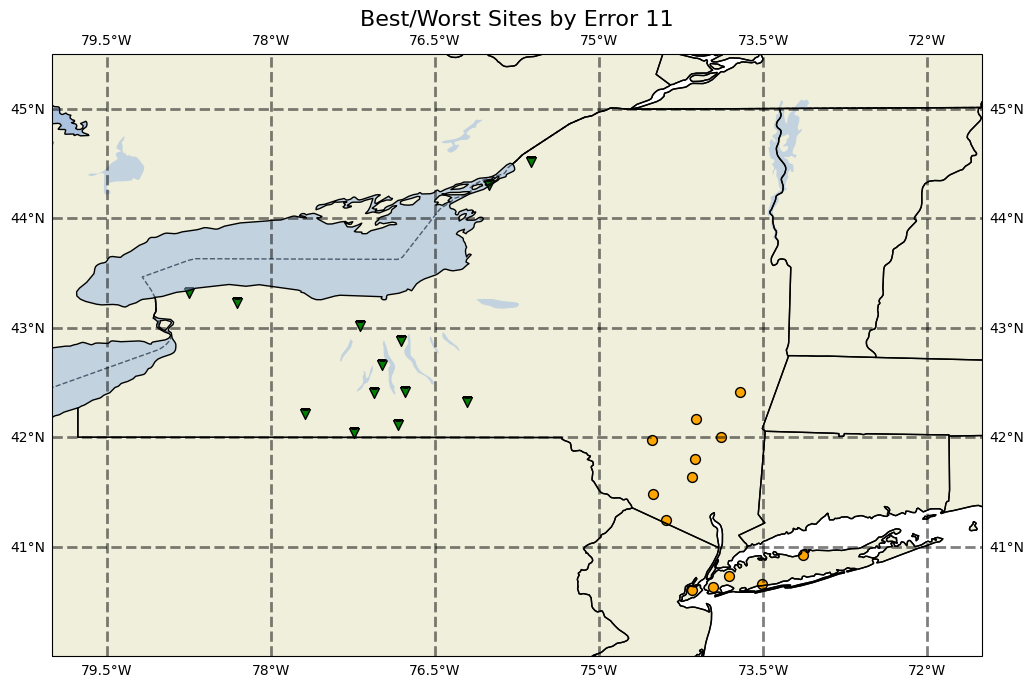

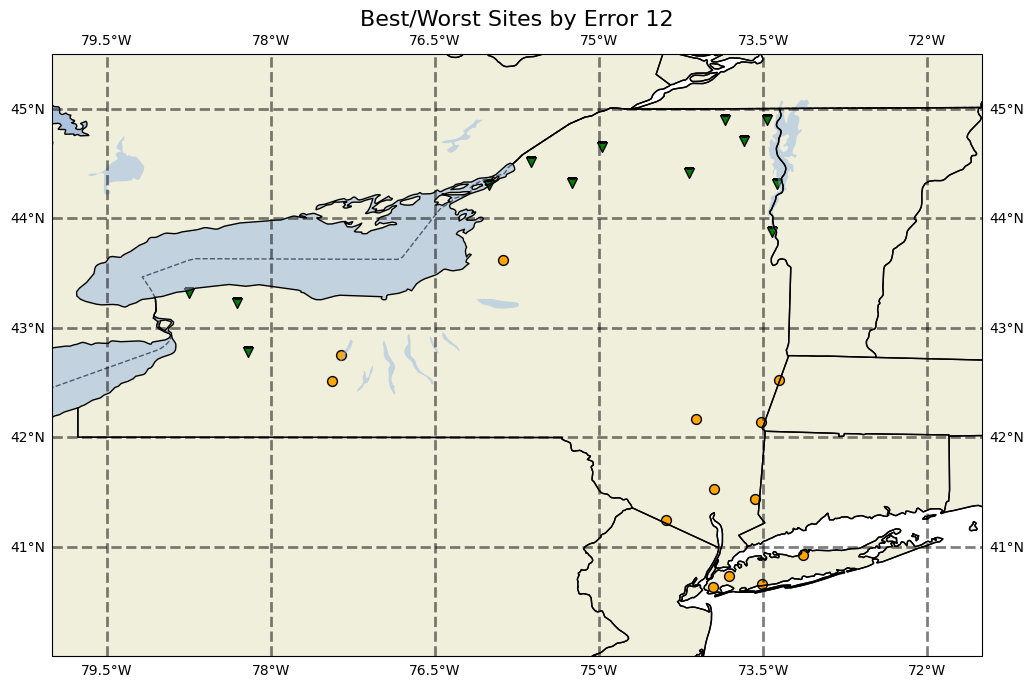

In [103]:
for i in np.arange(1, 13):
    # sort by month
    df_err = rmse_gfs.where(rmse_gfs["time"] == i).dropna()

    # get top and bottom
    top10 = df_err[:13]
    bottom10 = df_err[-13:]
    top10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_gfs.csv"
    )
    bottom10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_gfs.csv"
    )

    # plot
    count_plot(top10, bottom10, i)

In [104]:
tippity_df_gfs = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_gfs.csv"
    )
    tippity_df_gfs = pd.concat([df, tippity_df_gfs])

In [105]:
rockbott_df_gfs = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_gfs.csv"
    )
    rockbott_df_gfs = pd.concat([df, rockbott_df_gfs])

In [106]:
keys = tippity_df_gfs["station"].value_counts()[:13].keys()
keys

Index(['BURT', 'SARA', 'CAPE', 'CHAZ', 'WELL', 'POTS', 'EDWA', 'LOUI', 'ESSX',
       'BROC', 'TICO', 'ELLE', 'HAMM'],
      dtype='object')

In [107]:
plot_df_top_gfs = format_plot_df(tippity_df_gfs, keys)

In [108]:
keys = rockbott_df_gfs["station"].value_counts()[:13].keys()
keys

Index(['CLAR', 'TANN', 'MANH', 'BKLN', 'BRON', 'STAT', 'QUEE', 'STON', 'WANT',
       'COPA', 'REDF', 'ELDR', 'OSCE'],
      dtype='object')

In [109]:
plot_df_bott_gfs = format_plot_df(rockbott_df_gfs, keys)

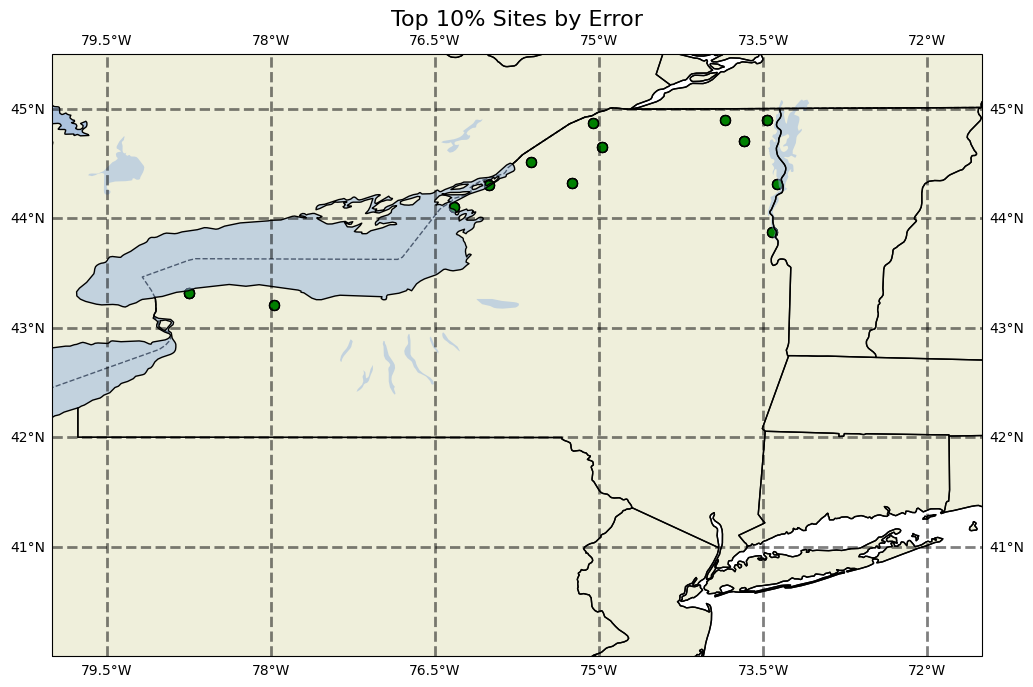

In [110]:
count_plot_top(plot_df_top_gfs)

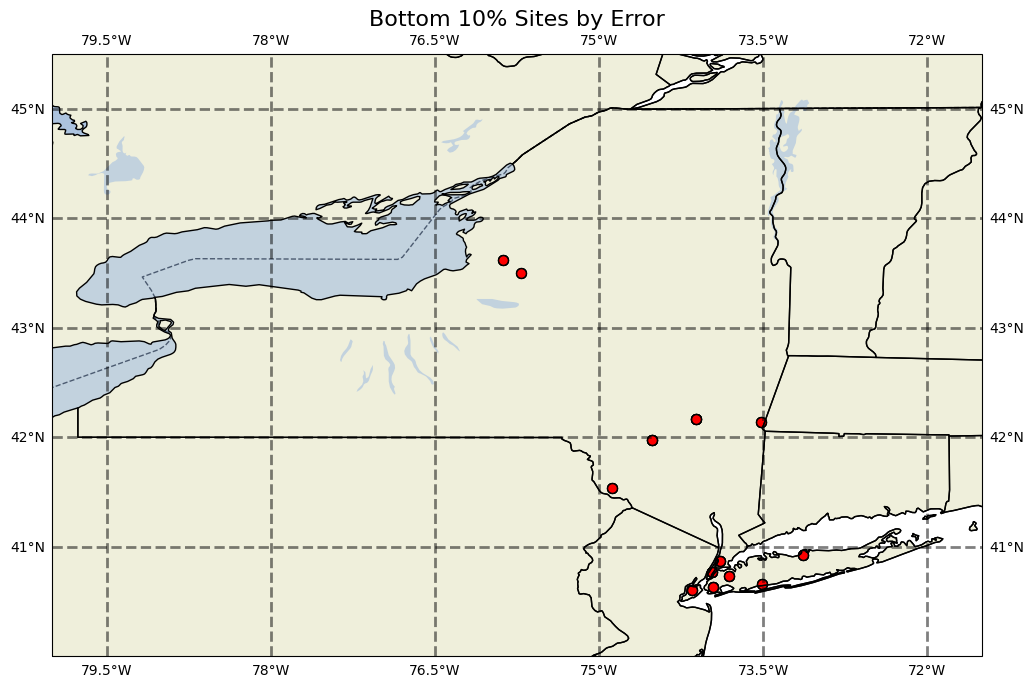

In [111]:
count_plot_bott(plot_df_bott_gfs)

# NAM

In [112]:
rmse_nam = rmse_to_plot[rmse_to_plot["NWP Model"] == "NAM"]
rmse_nam

time station  new_tp_error_sq NWP Model        lon        lat
170      2    ESSX         0.169368       NAM -73.371895  44.313602
233      2    TICO         0.176521       NAM -73.418793  43.874691
1285    11    CLIF         0.177799       NAM -77.185181  43.014790
148      2    CHES         0.184700       NAM -73.777359  43.653900
1340    11    PENN         0.189914       NAM -76.987457  42.655781
...    ...     ...              ...       ...        ...        ...
876      7    WEST         2.185700       NAM -75.461456  43.106468
769      7    BRON         2.316994       NAM -73.893524  40.872482
1112     9    STON         2.320878       NAM -73.131683  40.919121
916      8    DELE         2.334513       NAM -78.423203  42.418465
858      7    STAT         2.563670       NAM -74.148499  40.604015

[1512 rows x 6 columns]

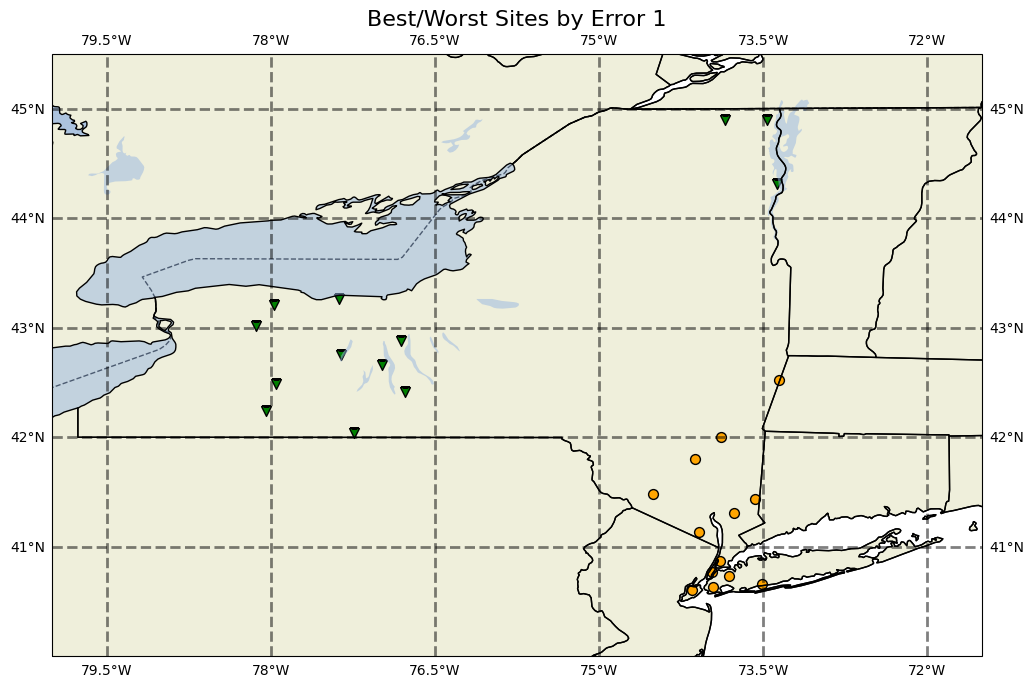

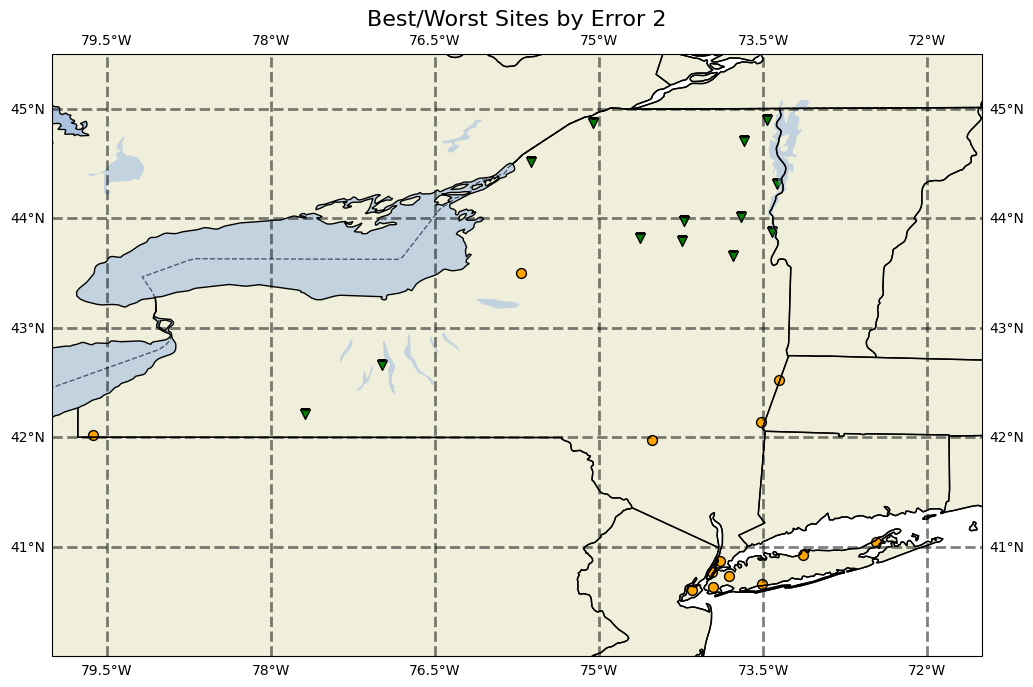

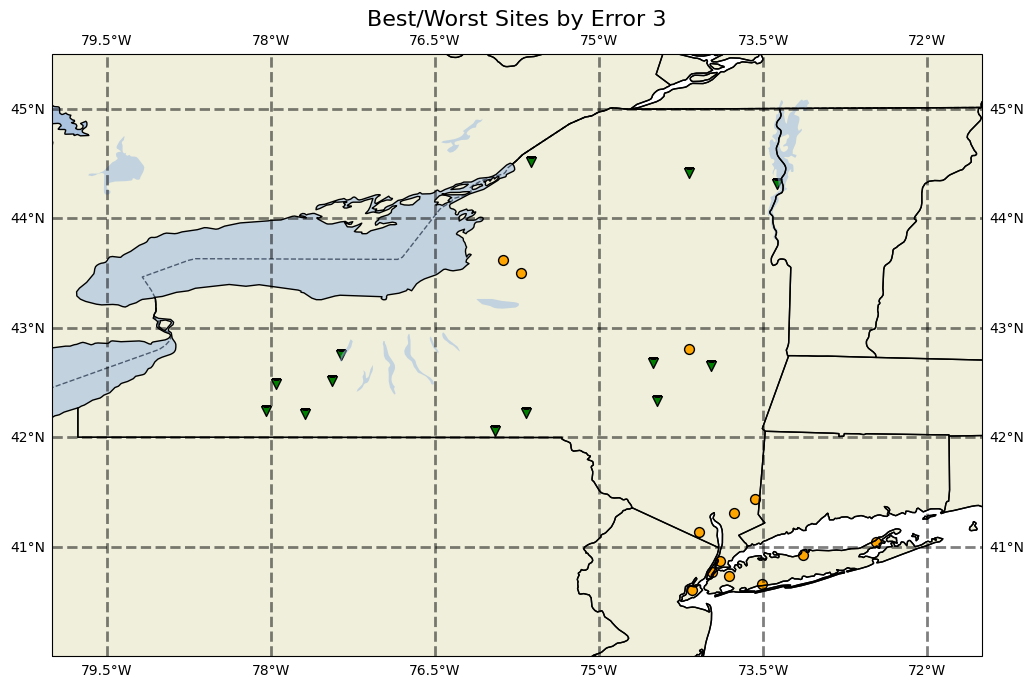

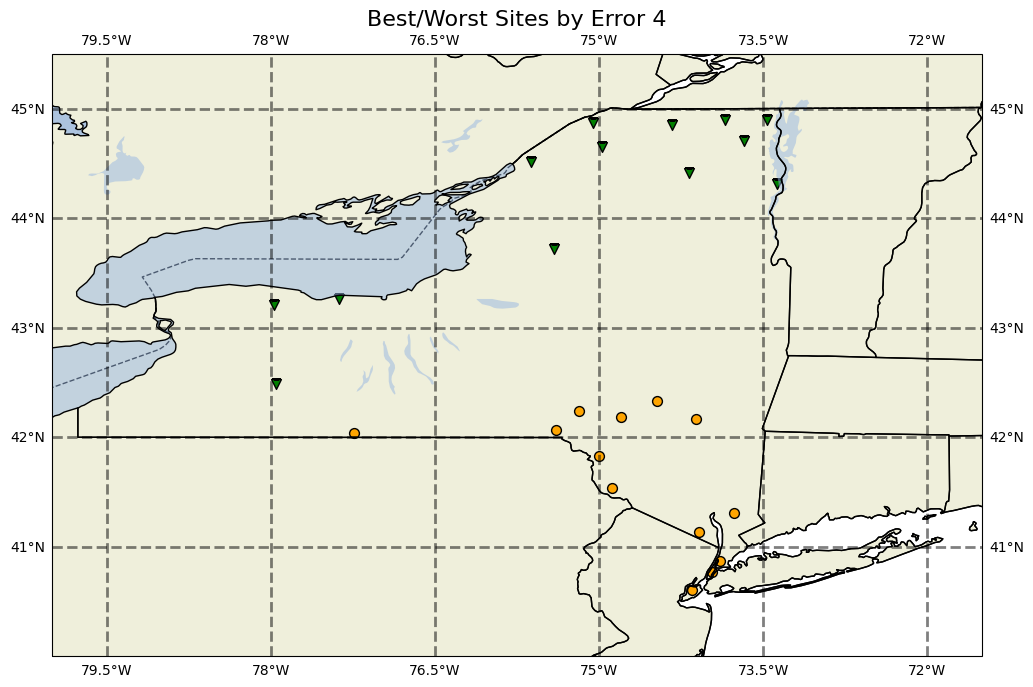

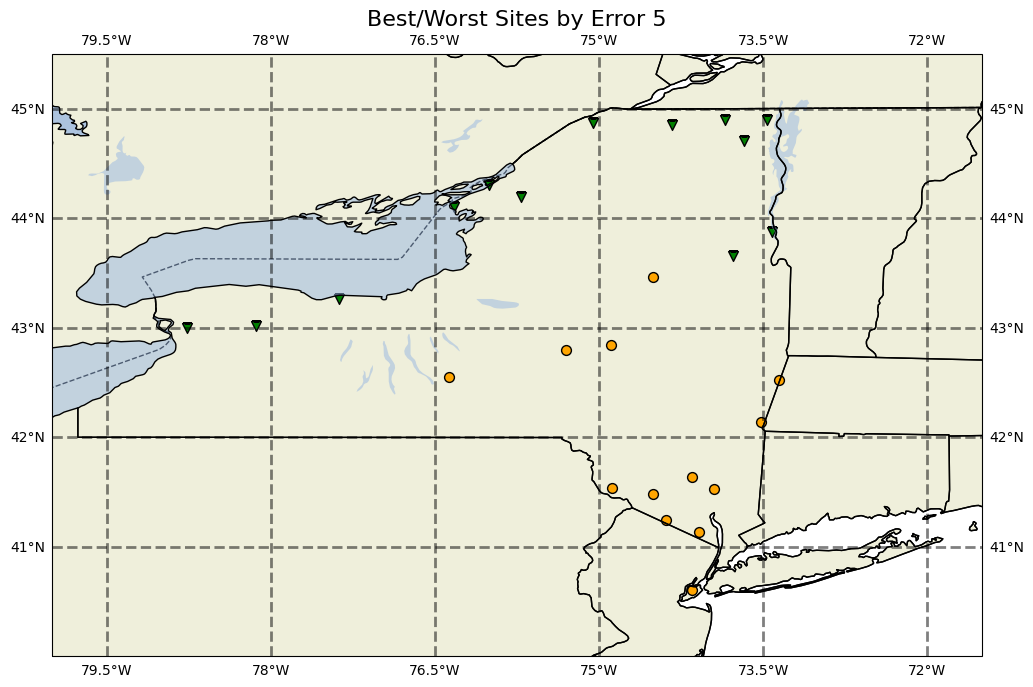

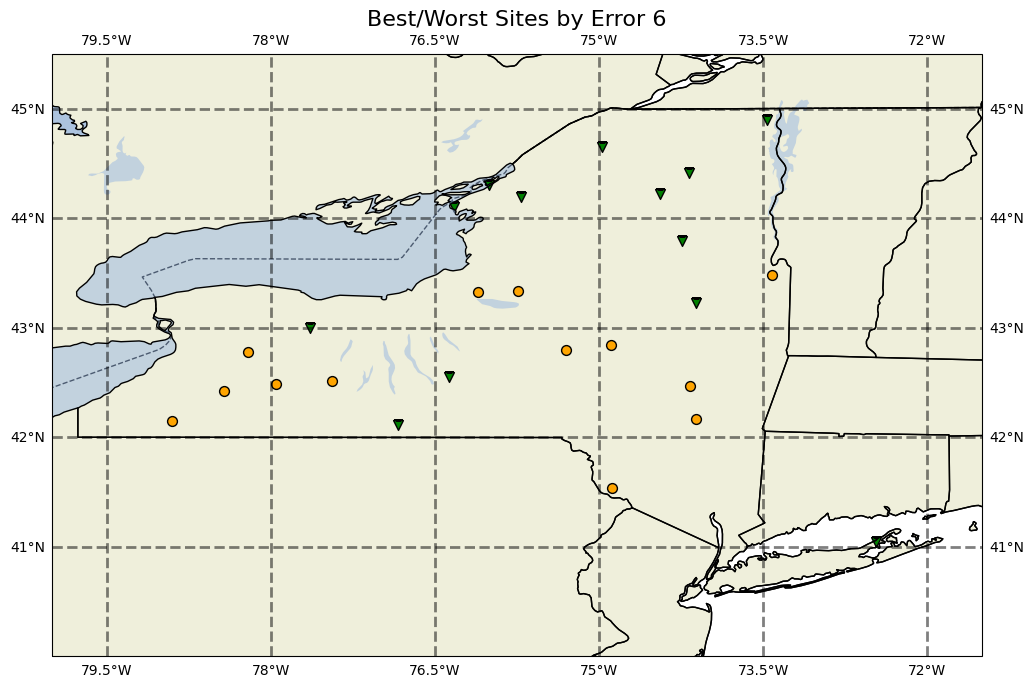

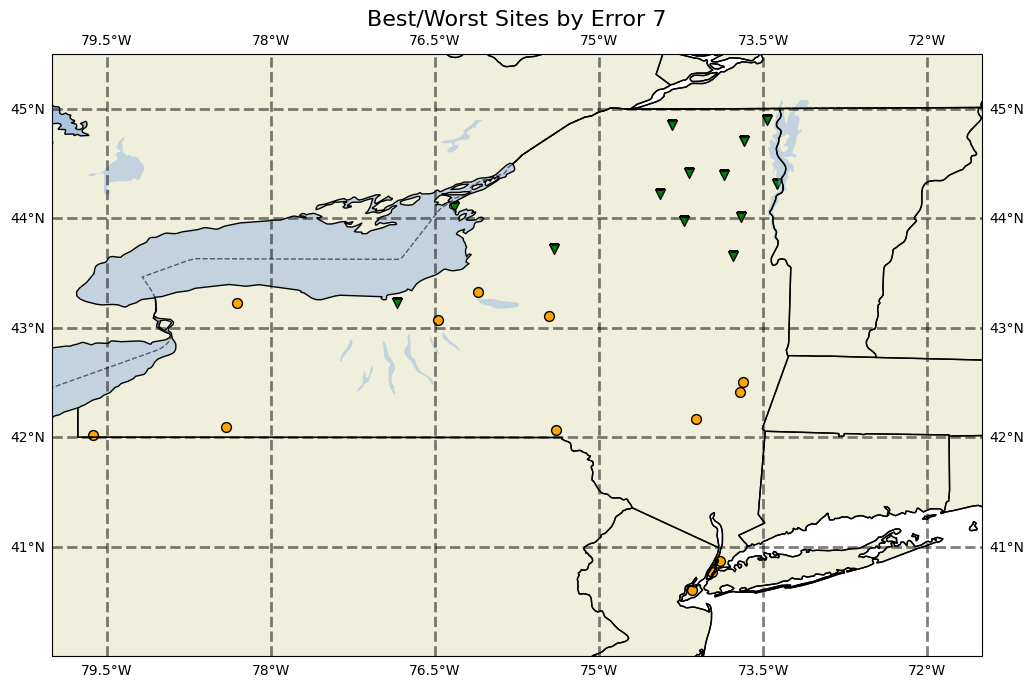

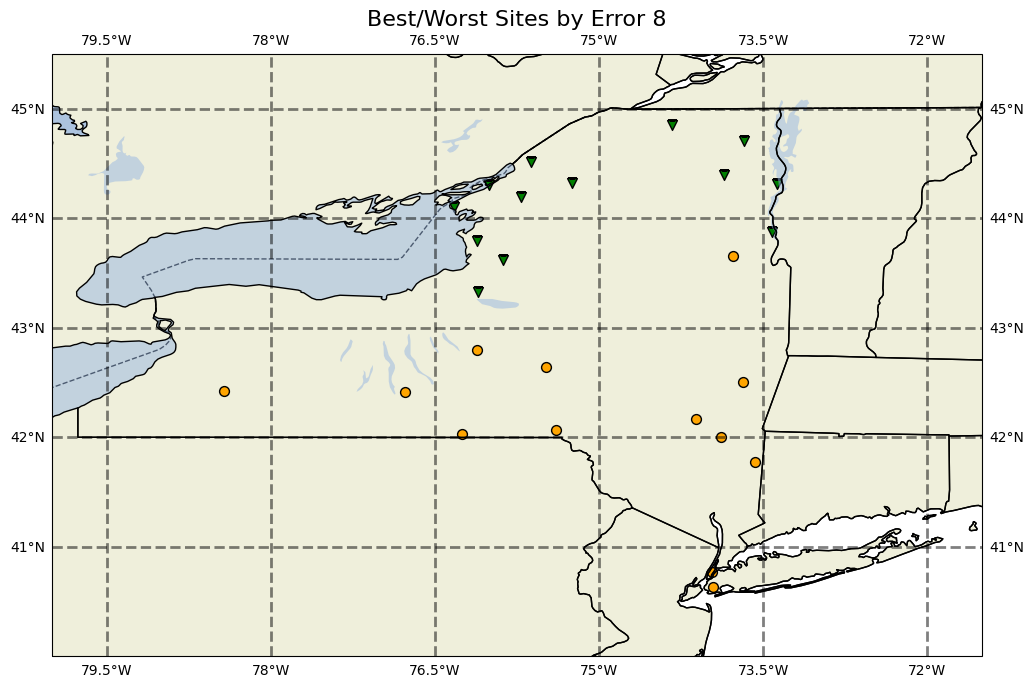

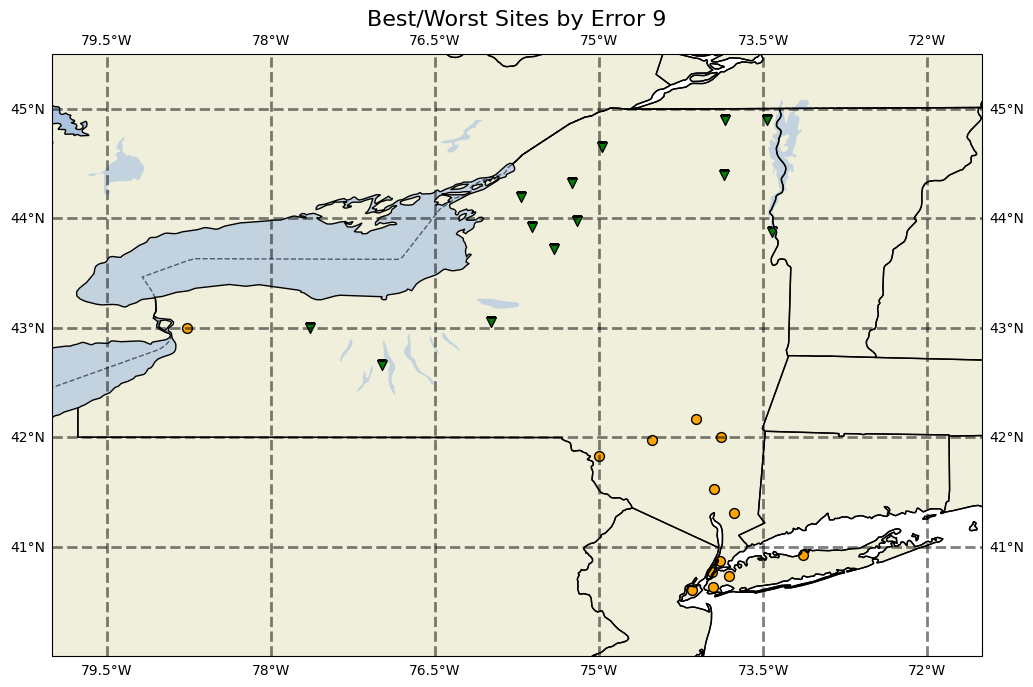

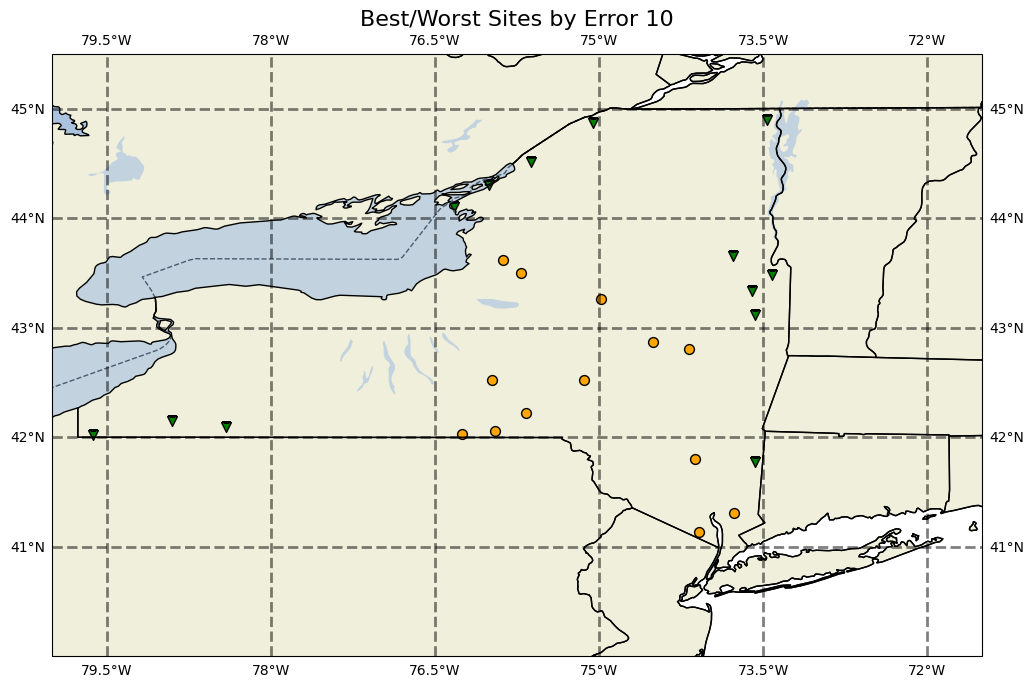

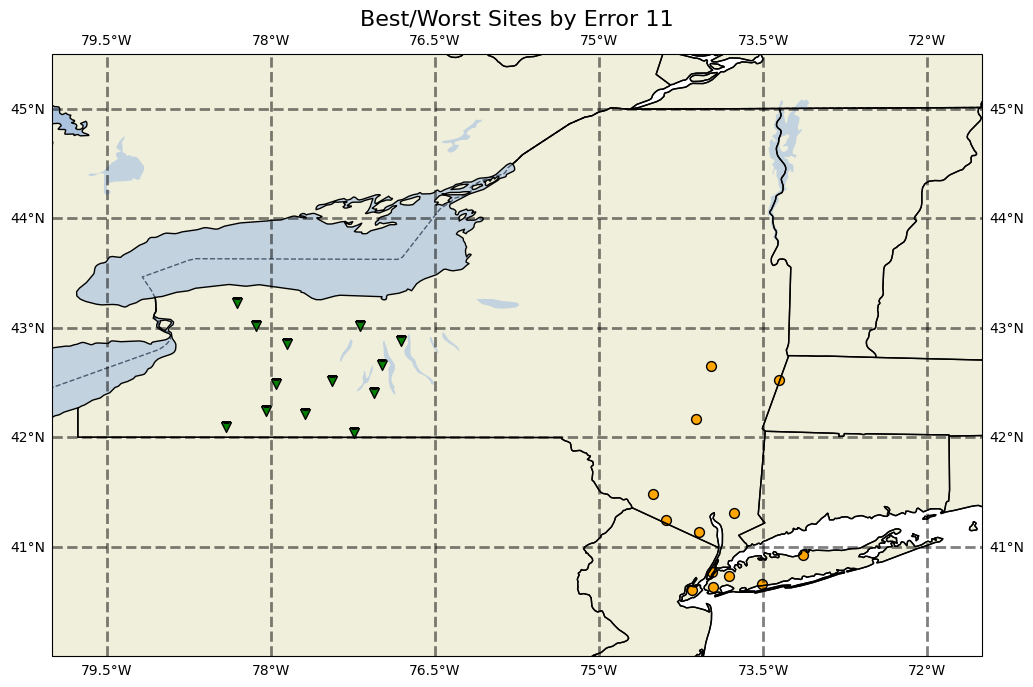

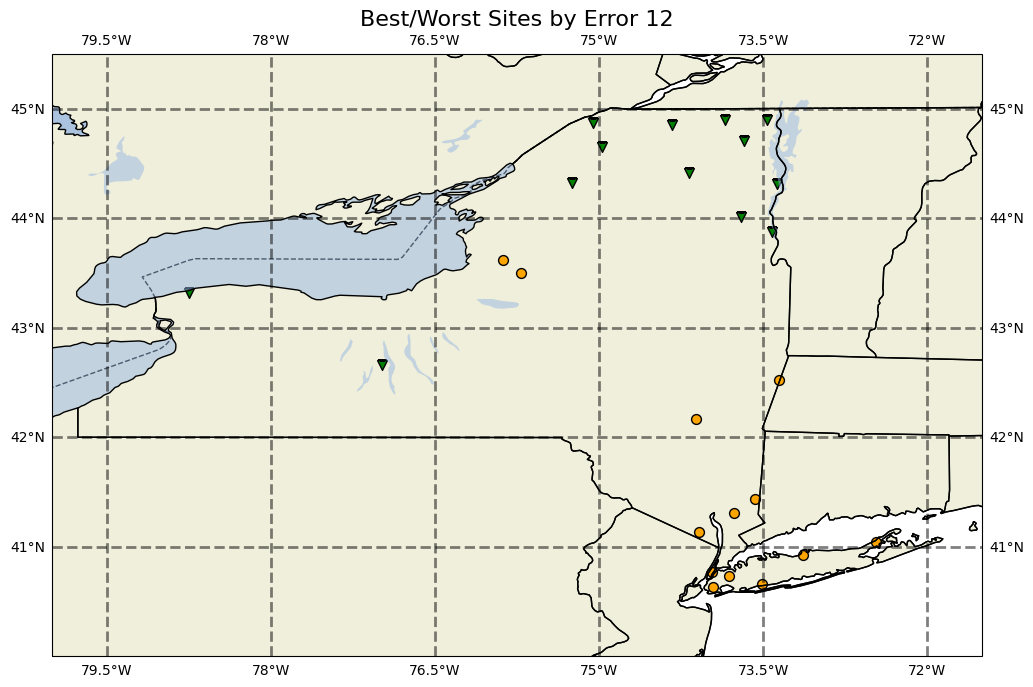

In [113]:
for i in np.arange(1, 13):
    # sort by month
    df_err = rmse_nam.where(rmse_nam["time"] == i).dropna()

    # get top and bottom
    top10 = df_err[:13]
    bottom10 = df_err[-13:]
    top10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_nam.csv"
    )
    bottom10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_nam.csv"
    )

    # plot
    count_plot(top10, bottom10, i)

In [114]:
tippity_df_nam = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_gfs.csv"
    )
    tippity_df_nam = pd.concat([df, tippity_df_nam])

In [115]:
rockbott_df_nam = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_gfs.csv"
    )
    rockbott_df_nam = pd.concat([df, rockbott_df_nam])

In [116]:
keys = tippity_df_nam["station"].value_counts()[:13].keys()
keys

Index(['BURT', 'SARA', 'CAPE', 'CHAZ', 'WELL', 'POTS', 'EDWA', 'LOUI', 'ESSX',
       'BROC', 'TICO', 'ELLE', 'HAMM'],
      dtype='object')

In [117]:
plot_df_top_nam = format_plot_df(tippity_df_nam, keys)

In [118]:
keys = rockbott_df_nam["station"].value_counts()[:13].keys()
keys

Index(['CLAR', 'TANN', 'MANH', 'BKLN', 'BRON', 'STAT', 'QUEE', 'STON', 'WANT',
       'COPA', 'REDF', 'ELDR', 'OSCE'],
      dtype='object')

In [119]:
plot_df_bott_nam = format_plot_df(rockbott_df_nam, keys)

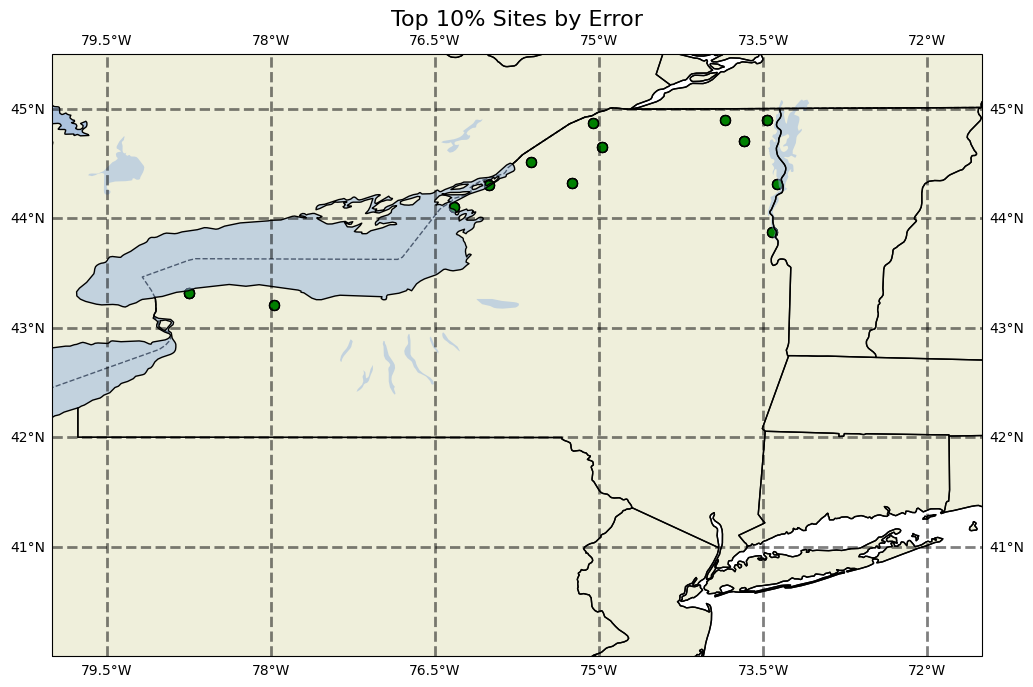

In [120]:
count_plot_top(plot_df_top_nam)

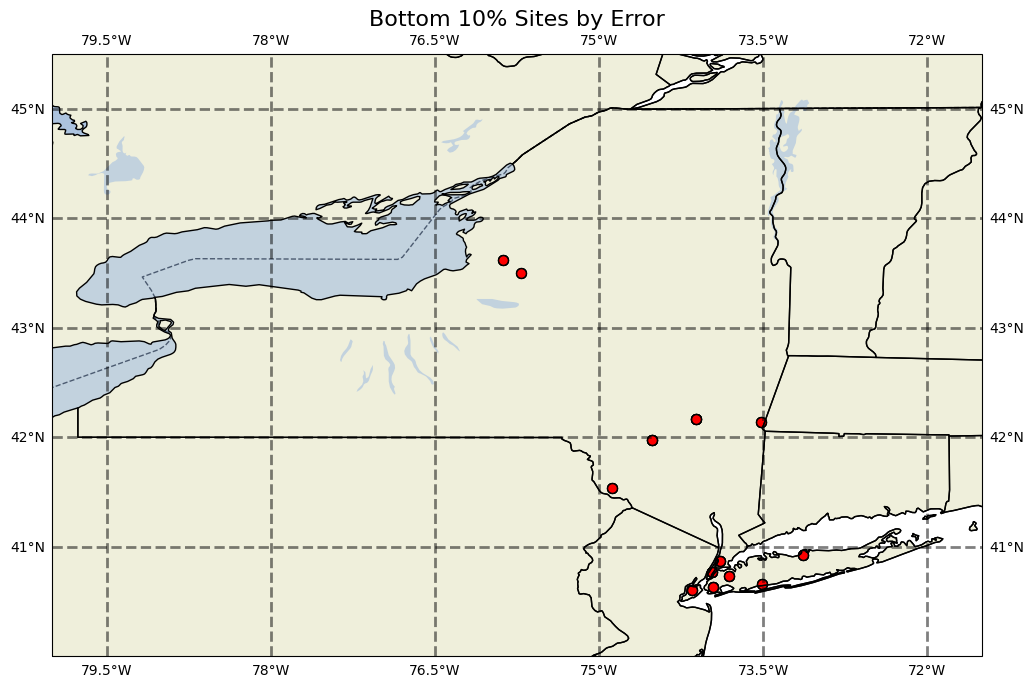

In [121]:
count_plot_bott(plot_df_bott_nam)

# Least Error

In [122]:
tops = pd.DataFrame()
tops = pd.concat([tippity_df, tops])
tops = pd.concat([tippity_df_gfs, tops])
tops = pd.concat([tippity_df_nam, tops])

In [123]:
tops

Unnamed: 0  time station  new_tp_error_sq NWP Model        lon        lat
0         1428  12.0    ELLE         0.437159       GFS -73.845016  44.895500
1         1430  12.0    ESSX         0.445841       GFS -73.371895  44.313602
2         1469  12.0    POTS         0.500643       GFS -74.974434  44.656868
3         1501  12.0    WARS         0.502732       GFS -78.208893  42.779930
4         1477  12.0    SARA         0.505939       GFS -73.671150  44.707584
..         ...   ...     ...              ...       ...        ...        ...
8           48   1.0    GFAL         0.281894      HRRR -73.602020  43.340870
9           44   1.0    ESSX         0.283309      HRRR -73.371895  44.313602
10         122   1.0    WGAT         0.286480      HRRR -75.158600  43.532410
11         101   1.0    SPRI         0.289902      HRRR -74.889610  42.843151
12          43   1.0    ELMI         0.290903      HRRR -76.836639  42.113319

[468 rows x 7 columns]

In [124]:
top_keys = tops["station"].value_counts()[:13].keys()
top_keys

Index(['CAPE', 'SARA', 'CHAZ', 'BURT', 'ESSX', 'LOUI', 'POTS', 'EDWA', 'WELL',
       'ELLE', 'BROC', 'ONTA', 'MALO'],
      dtype='object')

In [139]:
plot_df_tops = format_plot_df(tops, top_keys)

In [137]:
plot_df_tops

stations        lat        lon
0       ELLE  44.895500 -73.845016
1       ESSX  44.313602 -73.371895
2       POTS  44.656868 -74.974434
3       SARA  44.707584 -73.671150
4       EDWA  44.321770 -75.244133
..       ...        ...        ...
178     LOUI  44.871689 -75.056084
179     SARA  44.707584 -73.671150
180     POTS  44.656868 -74.974434
181     CHAZ  44.895649 -73.464607
182     ESSX  44.313602 -73.371895

[183 rows x 3 columns]

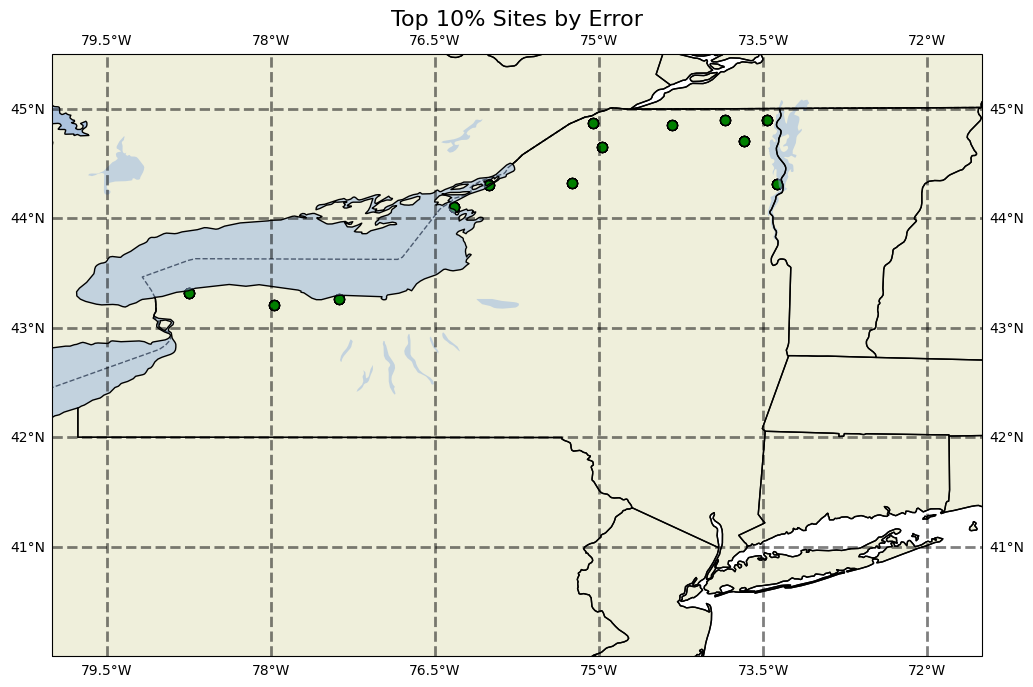

In [138]:
count_plot_top(plot_df_tops)

# Most Error

In [140]:
botts = pd.DataFrame()
botts = pd.concat([rockbott_df, botts])
botts = pd.concat([rockbott_df_gfs, botts])
botts = pd.concat([rockbott_df_nam, botts])

In [141]:
keys = botts["station"].value_counts()[:13].keys()
keys

Index(['MANH', 'BKLN', 'QUEE', 'TANN', 'BRON', 'CLAR', 'STAT', 'STON', 'ELDR',
       'REDF', 'WANT', 'WARW', 'SUFF'],
      dtype='object')

In [142]:
plot_df_botts = format_plot_df(botts, keys)

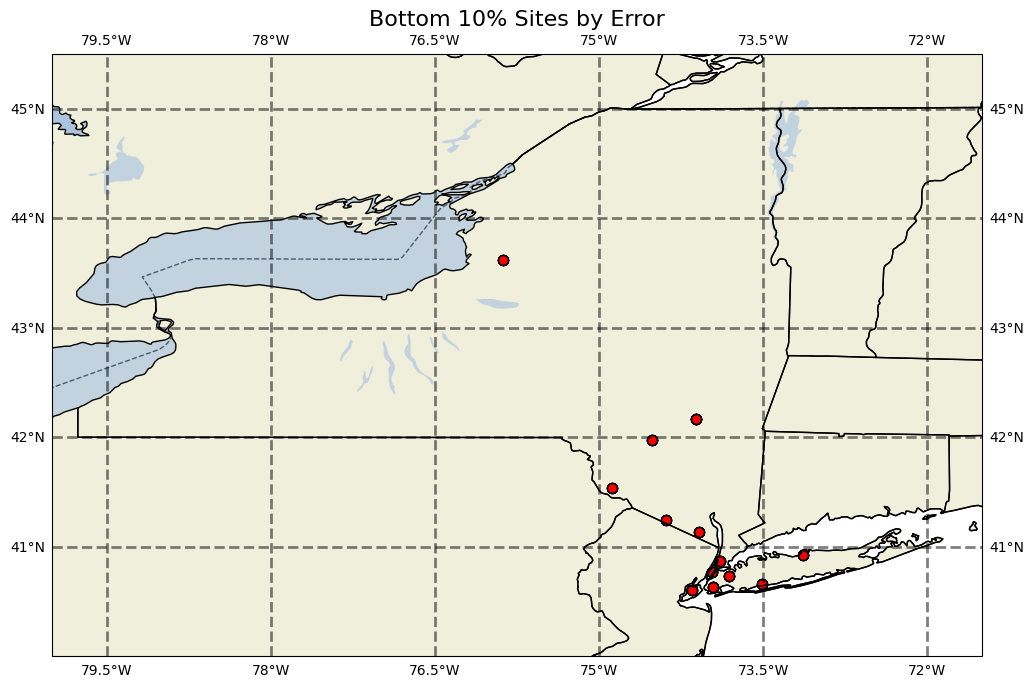

In [143]:
count_plot_bott(plot_df_botts)

In [144]:
bott_bott = get_monthly_rmse_data(18, "new_tp_error")
bott_bott = bott_bott[bott_bott["station"].isin(keys)]

GFS 1.3113581095370193
NAM 0.7274190036726051
HRRR 0.8196309490568423


In [145]:
top_top = get_monthly_rmse_data(18, "new_tp_error")
top_top = top_top[top_top["station"].isin(top_keys)]

GFS 1.3113581095370193
NAM 0.7274190036726051
HRRR 0.8196309490568423


In [146]:
bott_bott

time station  new_tp_error_sq NWP Model
9        1    BKLN         0.593194       GFS
13       1    BRON         0.716311       GFS
24       1    CLAR         0.727221       GFS
41       1    ELDR         0.605380       GFS
65       1    MANH         0.632298       GFS
...    ...     ...              ...       ...
1490    12    STON         0.652512      HRRR
1491    12    SUFF         0.537153      HRRR
1492    12    TANN         0.481419      HRRR
1500    12    WANT         0.607552      HRRR
1502    12    WARW         0.525364      HRRR

[468 rows x 4 columns]

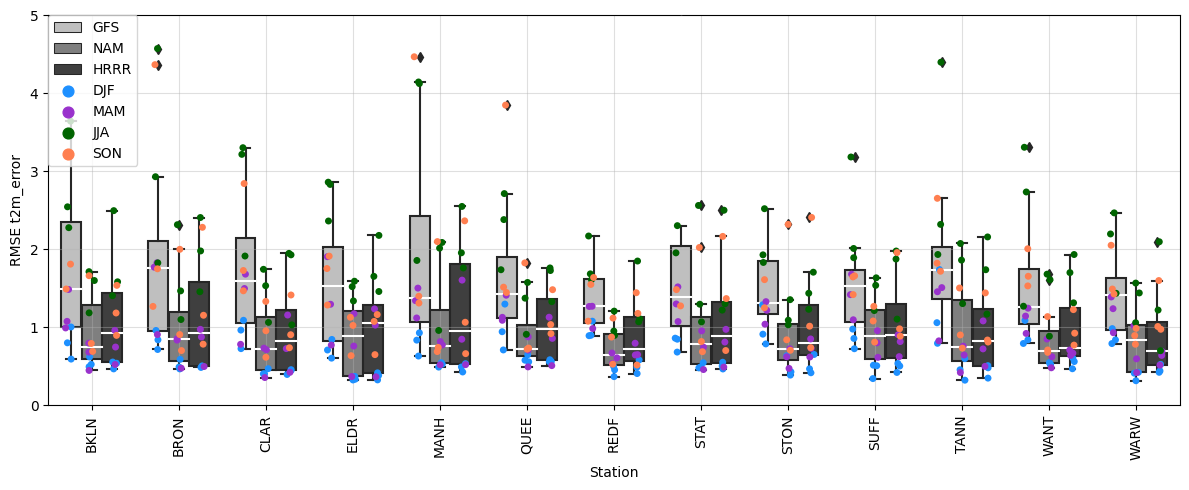

In [161]:
plot_rmse_boxplots(bott_bott, 17, "new_tp_error")

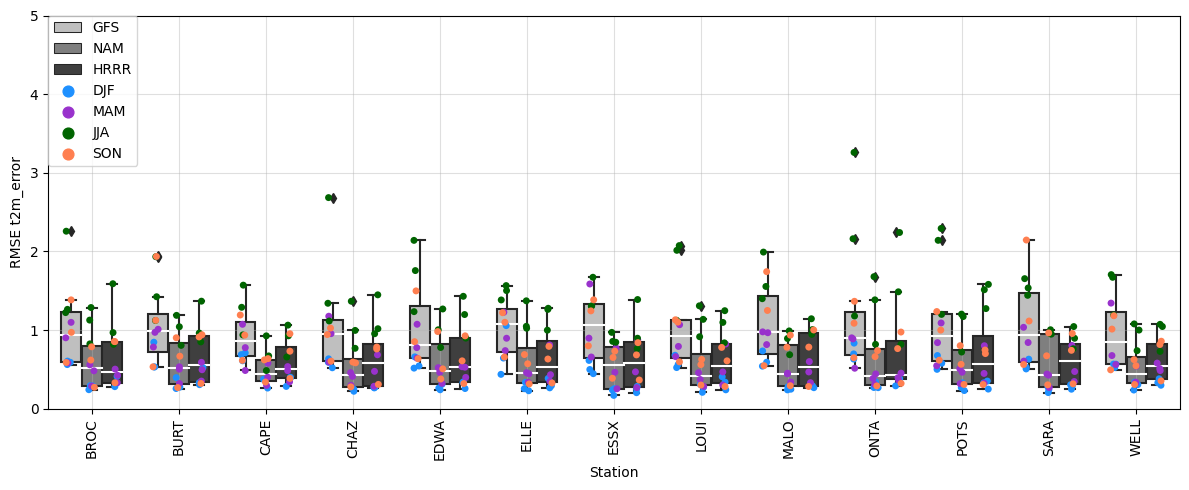

In [162]:
plot_rmse_boxplots(top_top, 17, "new_tp_error")

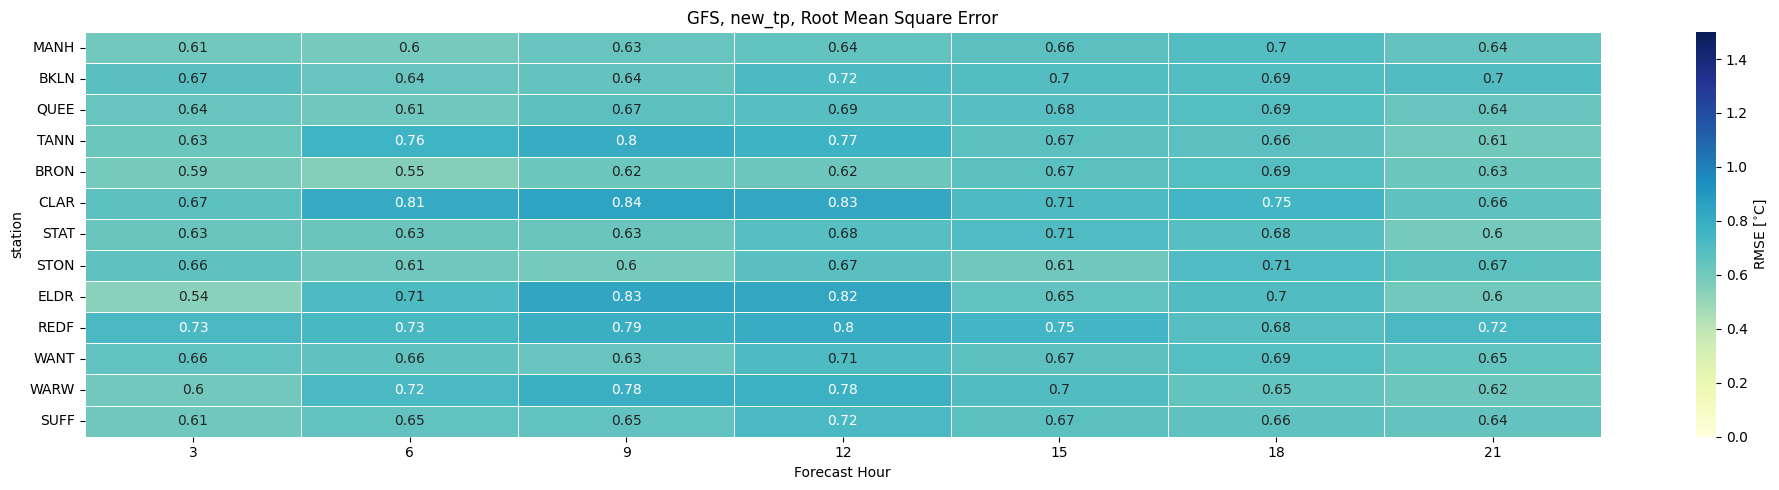

In [154]:
var = "new_tp_error"
units = "$^{\circ}$C"
plot_model_rmse_heatmap_fhours_clim_divs(
    "GFS", gfs_fcast_and_error_df, var, units, var_val_range.get(var), keys
)

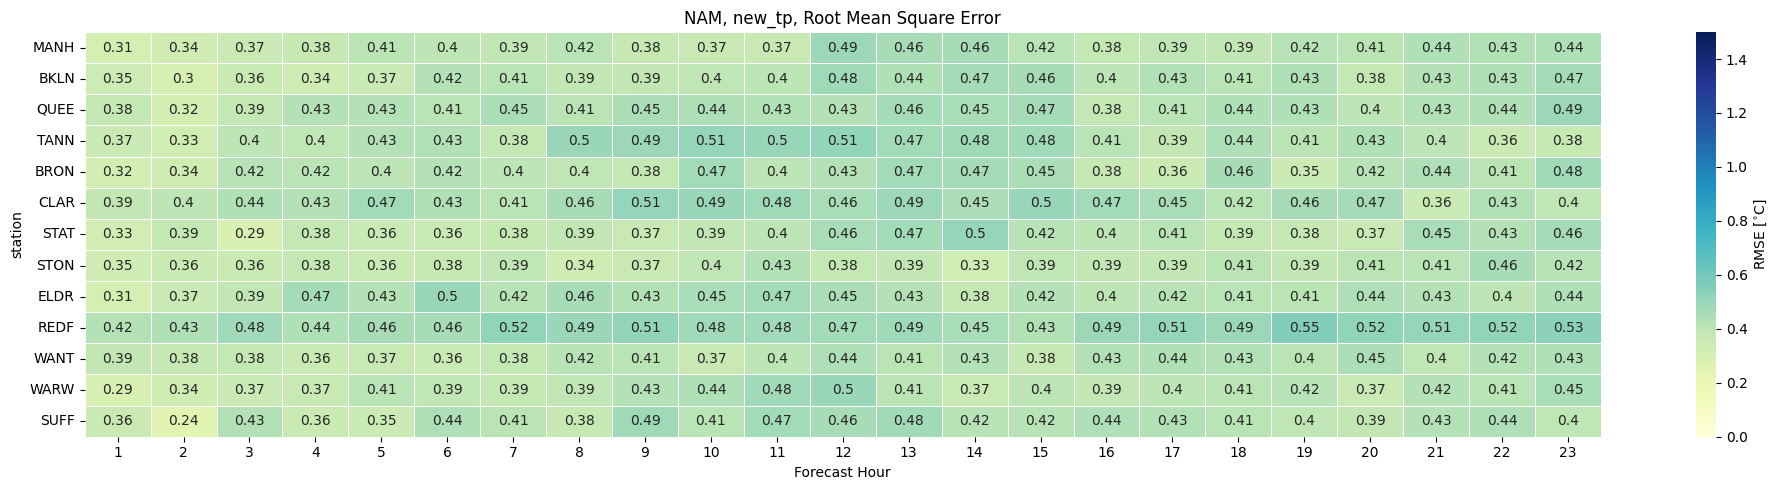

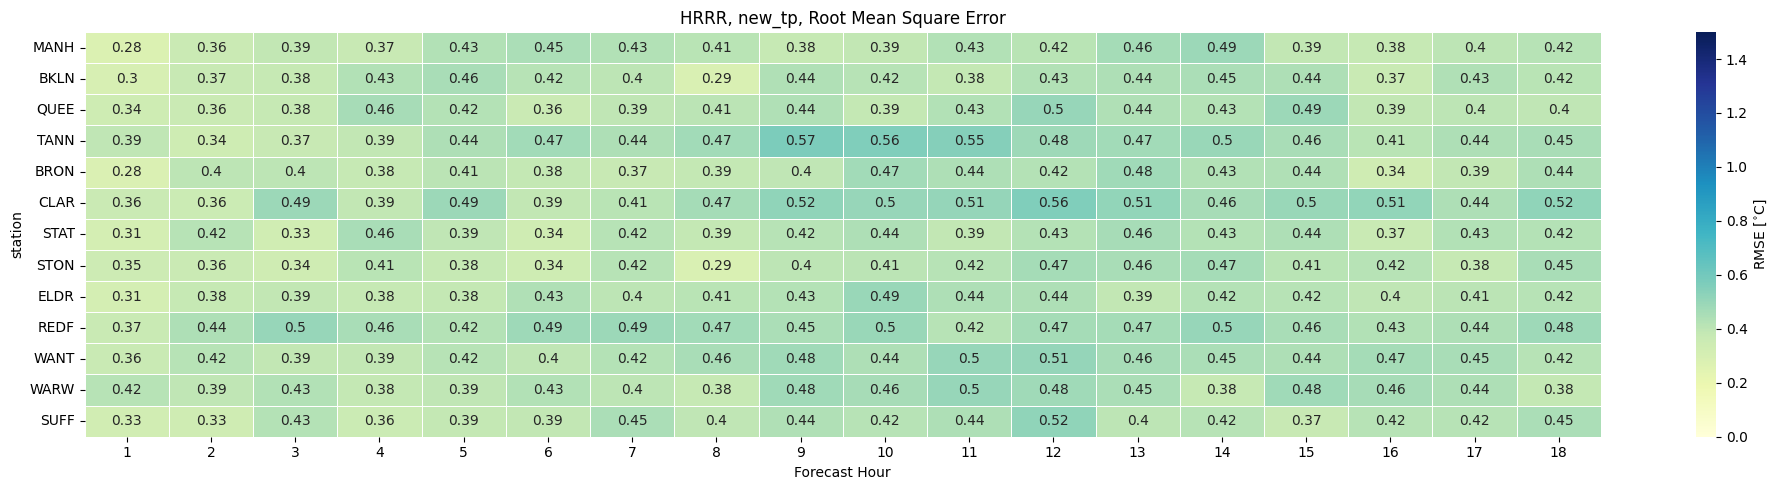

In [155]:
plot_model_rmse_heatmap_fhours_clim_divs(
    "NAM", nam_fcast_and_error_df, var, units, var_val_range.get(var), keys
)
plot_model_rmse_heatmap_fhours_clim_divs(
    "HRRR", hrrr_fcast_and_error_df, var, units, var_val_range.get(var), keys
)